**1. LOAD THE REQUIREMENTS**

In [1]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!ip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
!pip install tensorflow
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
"ip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import DataLoader,Dataset, Subset 
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score
import os
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from torch.optim.lr_scheduler import StepLR
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    classification_report
)

**2. LOAD FUNCTIONS**

In [2]:
def prepare_labels(csv_path, label_mapping=None):
    df = pd.read_csv(csv_path)
    class_columns = df.columns[1:]
    df['label_name'] = df[class_columns].idxmax(axis=1)
    
    if label_mapping is None:
        label_mapping = {name: idx for idx, name in enumerate(class_columns)}
    
    df['label_idx'] = df['label_name'].map(label_mapping)
    return df, label_mapping

train_df, label_mapping = prepare_labels('D:/TFM/ISIC2018_Task3_Training_GroundTruth.csv')
val_df, _ = prepare_labels('D:/TFM/ISIC2018_Task3_Validation_GroundTruth.csv', label_mapping)
test_df, _ = prepare_labels('D:/TFM/ISIC2018_Task3_Test_GroundTruth.csv', label_mapping)

In [3]:
class ISICDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image'] + '.jpg')
        image = Image.open(image_path).convert('RGB')
        
        label = row['label_idx']
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ISICDataset(train_df, 'D:/TFM/ISIC2018_Task3_Training_Input', transform=train_transform)
val_dataset   = ISICDataset(val_df, 'D:/TFM/ISIC2018_Task3_Validation_Input', transform=val_test_transform)
test_dataset  = ISICDataset(test_df, 'D:/TFM/ISIC2018_Task3_Test_Input', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def compute_class_weights(df, label_column='label_idx', num_classes=7):
    class_counts = df[label_column].value_counts().sort_index()

    total = class_counts.sum()
    weights = total / (num_classes * class_counts)  

    class_weights = torch.tensor(weights.values, dtype=torch.float)
    return class_weights


class_weights = compute_class_weights(train_df)


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_wts = None

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            if self.verbose:
                if self.best_loss == float('inf'):
                    print(f'Validation loss initialized to {val_loss:.4f}. Saving model...')
                else:
                    print(f'Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...')
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = model.state_dict()
            torch.save(self.best_model_wts, self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve. Counter: {self.counter}/{self.patience}')
        if self.counter >= self.patience:
            print('Early stopping triggered')
            return True
        return False


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # ← Actualizado para 224x224
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


**4. RESNET18 MODEL**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(pretrained=True)

num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, device,
          label_mapping, num_epochs=20, patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    class_names = list(label_mapping.keys())

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_preds = []
        val_labels = []
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * images.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)

        val_bal_acc = balanced_accuracy_score(val_labels, val_preds)
        per_class_recall = recall_score(val_labels, val_preds, average=None)
        val_accuracies.append(val_bal_acc)

        if val_bal_acc > best_acc:
            best_acc = val_bal_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Modelo guardado (mejor hasta ahora: {best_acc:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No mejora ({epochs_no_improve}/{patience})")

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val Balanced Accuracy: {val_bal_acc:.4f}")
        print("  Accuracy por clase:")
        for i, class_name in enumerate(class_names):
            print(f"    {class_name}: {per_class_recall[i]:.4f}")

        if epochs_no_improve >= patience:
            print("\nDetenido por early stopping.")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='train_loss', color='blue')
    plt.plot(val_losses, label='val_loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nEvaluando el mejor modelo en el conjunto de validación...")

    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    best_val_preds = []
    best_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            best_val_preds.extend(preds.cpu().numpy())
            best_val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(best_val_labels, best_val_preds, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix (Best Model)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

Modelo guardado (mejor hasta ahora: 0.6904)

Epoch 1/20
  Train Loss: 0.6928
  Val Loss: 0.6805
  Val Balanced Accuracy: 0.6904
  Accuracy por clase:
    MEL: 0.7619
    NV: 0.7154
    BCC: 0.8667
    AKIEC: 0.6250
    BKL: 0.8636
    DF: 0.0000
    VASC: 1.0000
Modelo guardado (mejor hasta ahora: 0.8228)

Epoch 2/20
  Train Loss: 0.5570
  Val Loss: 0.5209
  Val Balanced Accuracy: 0.8228
  Accuracy por clase:
    MEL: 0.7143
    NV: 0.8049
    BCC: 0.9333
    AKIEC: 0.6250
    BKL: 0.6818
    DF: 1.0000
    VASC: 1.0000
No mejora (1/10)

Epoch 3/20
  Train Loss: 0.4568
  Val Loss: 0.4907
  Val Balanced Accuracy: 0.7832
  Accuracy por clase:
    MEL: 0.6667
    NV: 0.8049
    BCC: 0.5333
    AKIEC: 0.7500
    BKL: 0.7273
    DF: 1.0000
    VASC: 1.0000
Modelo guardado (mejor hasta ahora: 0.8374)

Epoch 4/20
  Train Loss: 0.4410
  Val Loss: 0.5747
  Val Balanced Accuracy: 0.8374
  Accuracy por clase:
    MEL: 0.7619
    NV: 0.7886
    BCC: 0.8000
    AKIEC: 0.8750
    BKL: 0.6364
    DF:

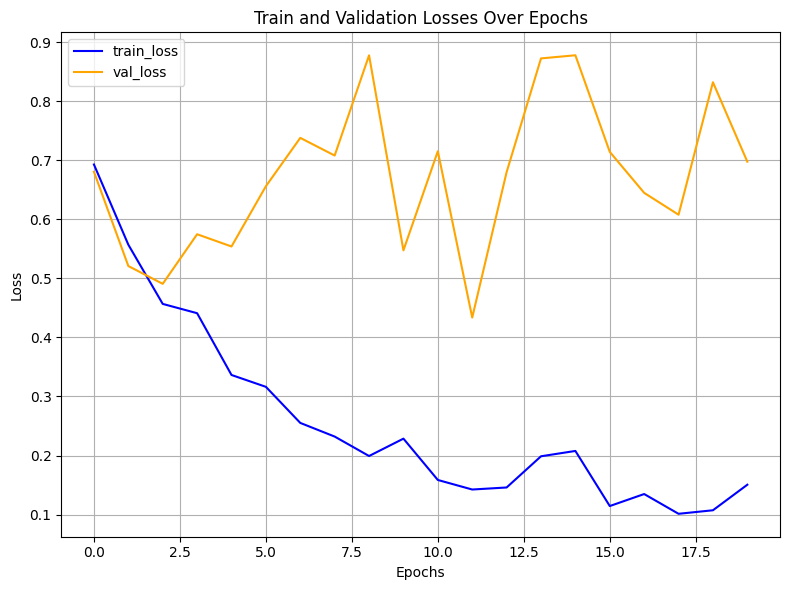


Evaluando el mejor modelo en el conjunto de validación...


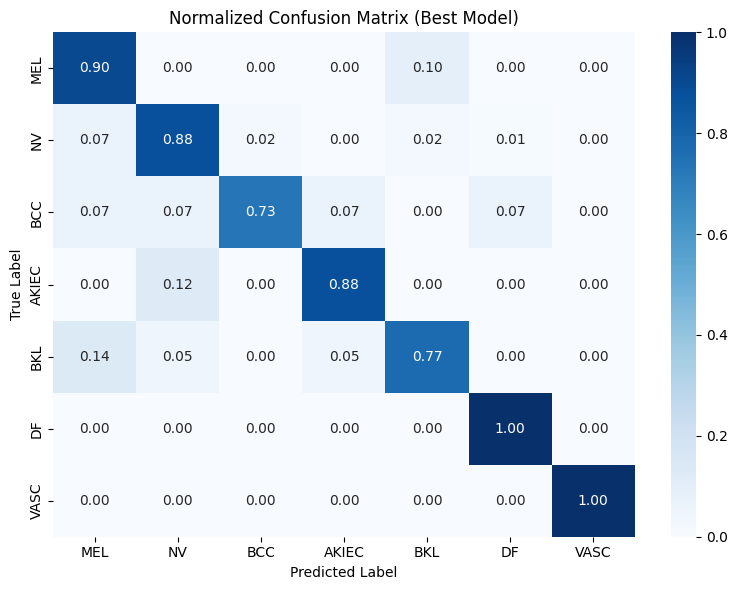

In [128]:
train(model, train_loader, val_loader, criterion, optimizer, device,label_mapping, num_epochs=20, patience=10)


✅ Test Balanced Accuracy: 0.7110
📊 Accuracy por clase en el test set:
  MEL: 0.6550
  NV: 0.8130
  BCC: 0.7527
  AKIEC: 0.7907
  BKL: 0.6498
  DF: 0.6591
  VASC: 0.6571


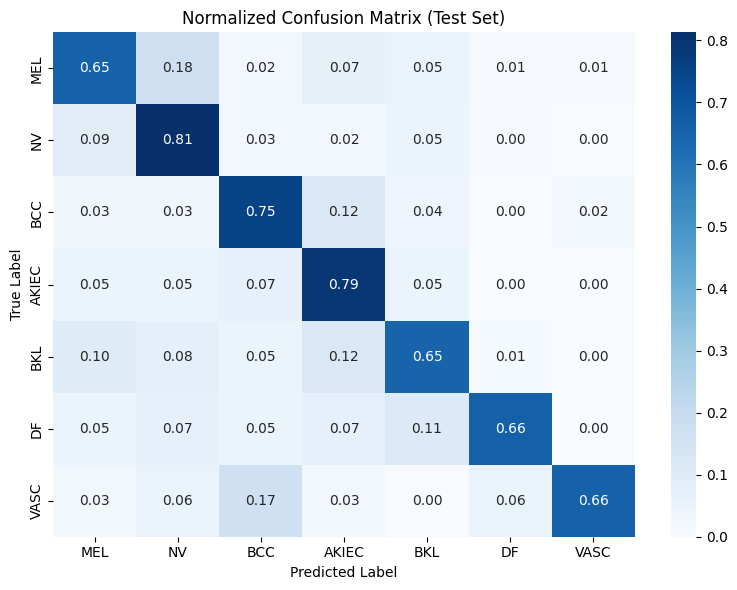

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
test_recall_per_class = recall_score(test_labels, test_preds, average=None)

print(f"\n Test Balanced Accuracy: {test_bal_acc:.4f}")
print(" Accuracy por clase en el test set:")
for i, class_name in enumerate(label_mapping.keys()):
    print(f"  {class_name}: {test_recall_per_class[i]:.4f}")

cm = confusion_matrix(test_labels, test_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_mapping.keys(),
            yticklabels=label_mapping.keys())
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

**4. CROSS VALIDATION**

**4.1 SIMPLE CNN**

**4.1.1 WITH CLASS WEIGHTING**


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.2459. Saving model...
Validation loss decreased (1.2459 -> 1.2332). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss decreased (1.2332 -> 1.1676). Saving model...
Validation loss decreased (1.1676 -> 1.0930). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.0930 -> 1.0568). Saving model...
Validation loss decreased (1.0568 -> 1.0165). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss decreased (1.0165 ->

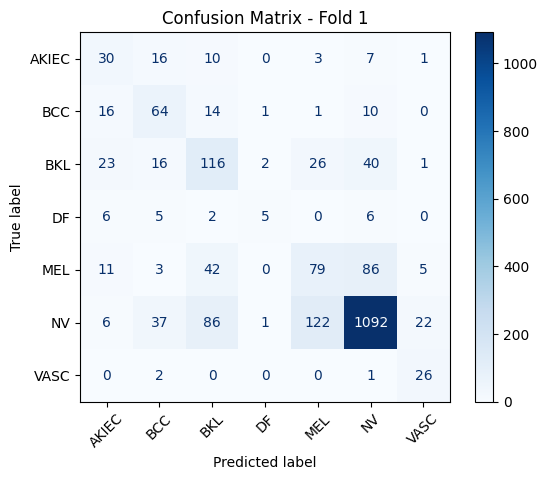


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.5470. Saving model...
Validation loss decreased (1.5470 -> 1.2876). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.2876 -> 1.2836). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.2836 -> 1.0723). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss decreased (1.0723 -> 1.0416). Saving model...
Validation loss did not improve. Counter: 1/10
Vali

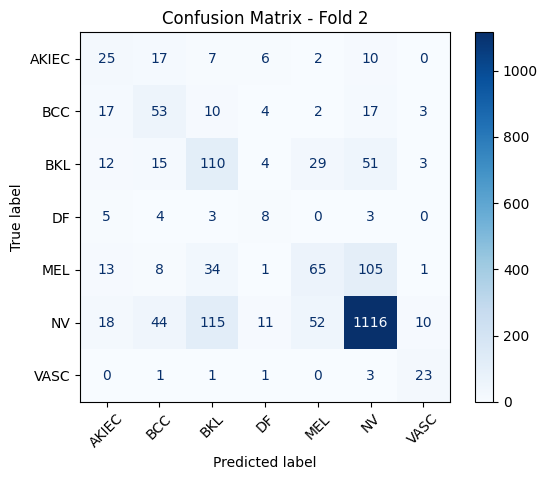


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.3403. Saving model...
Validation loss decreased (1.3403 -> 1.2139). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. Counter: 6/10
Validation loss decreased (1.2139 -> 1.0287). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. C

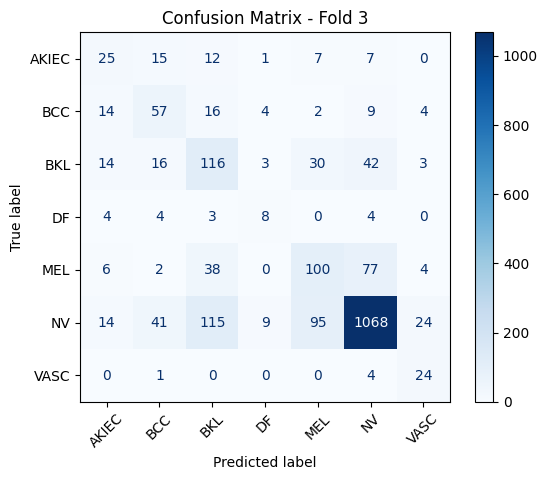


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Validation loss initialized to 1.5285. Saving model...
Validation loss decreased (1.5285 -> 1.3736). Saving model...
Validation loss decreased (1.3736 -> 1.3376). Saving model...
Validation loss decreased (1.3376 -> 1.2657). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss decreased (1.2657 -> 1.1826). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Vali

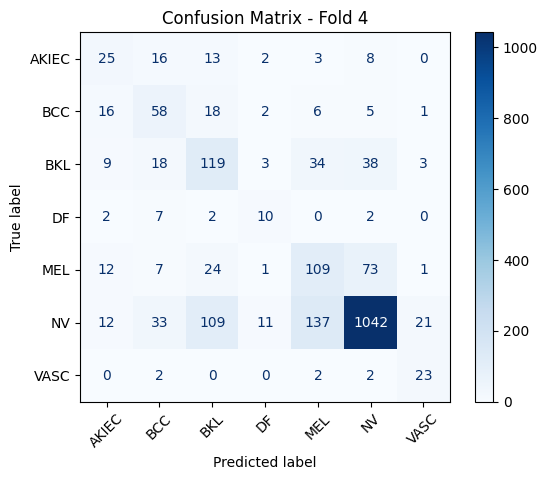


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Validation loss initialized to 1.3908. Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.3908 -> 1.2005). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss decreased (1.2005 -> 1.1408). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.1408 -> 1.0773). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.0773 -> 0.9401). Saving model...
Vali

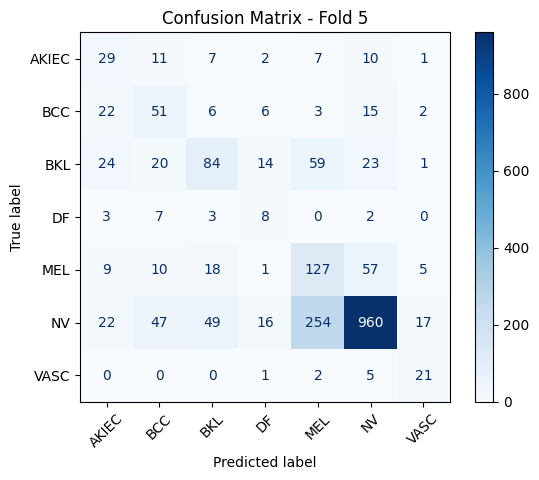


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.3018    0.4000    0.3440       335
         BCC     0.3997    0.5350    0.4576       529
         BKL     0.4186    0.4862    0.4499      1121
          DF     0.2671    0.3362    0.2977       116
         MEL     0.3535    0.4233    0.3852      1134
          NV     0.8797    0.7730    0.8229      6828
        VASC     0.4680    0.8069    0.5924       145

    accuracy                         0.6736     10208
   macro avg     0.4412    0.5372    0.4785     10208
weighted avg     0.7139    0.6736    0.6894     10208



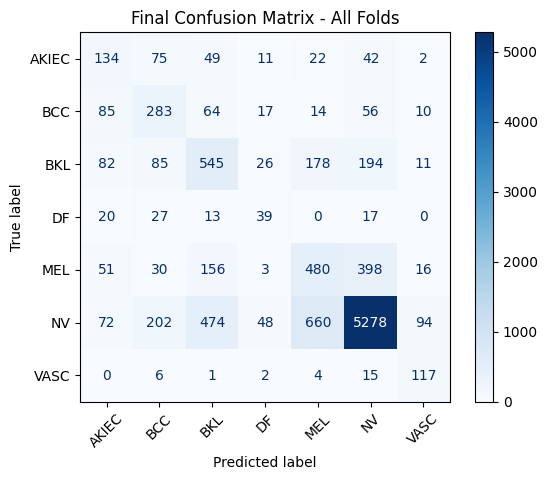

In [26]:
data_path = r"D:\TFM\data\train_val_full"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    num_classes = len(class_counts)
    weights = [
        total / (num_classes * class_counts[i]) if class_counts[i] > 0 else 0.0
        for i in range(num_classes)
    ]
    weights = torch.FloatTensor(weights)
    class_weights = weights.to(device)

    print("Class Weights (Fold {}):".format(fold+1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")


    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'best_model_fold{fold}.pth')

    for epoch in range(50):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        if early_stopping(model, val_loss / len(val_loader)):
            break

    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))

    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()

Evaluando modelo fold 0 en el test set...
Evaluando modelo fold 1 en el test set...
Evaluando modelo fold 2 en el test set...
Evaluando modelo fold 3 en el test set...
Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (Ensamble de 5 Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.2239    0.3488    0.2727        43
         BCC     0.3636    0.4301    0.3941        93
         BKL     0.4038    0.3963    0.4000       217
          DF     0.2778    0.1136    0.1613        44
         MEL     0.3540    0.4678    0.4030       171
          NV     0.8361    0.7635    0.7982       909
        VASC     0.3333    0.4571    0.3855        35

    accuracy                         0.6190      1512
   macro avg     0.3989    0.4253    0.4021      1512
weighted avg     0.6452    0.6190    0.6284      1512



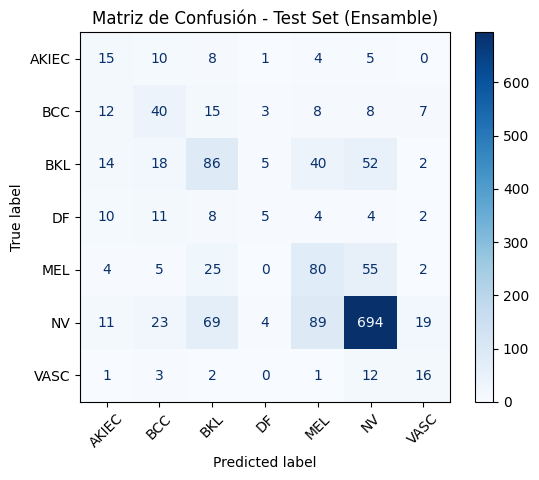

In [28]:
test_data_path = r"D:\TFM\ISIC2018\test"
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_labels = [label for _, label in test_dataset]

all_test_preds = []

for fold in range(k_folds):
    print(f"Evaluando modelo fold {fold} en el test set...")
    model = SimpleCNN(num_classes=7).to(device)
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    
    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.append(preds.cpu().numpy())
    
    all_test_preds.append(np.concatenate(fold_preds))

all_test_preds = np.array(all_test_preds)

ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_test_preds)

print("\n======== Resultados del Test Set (Ensamble de 5 Folds) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))

cm_test_ensemble = confusion_matrix(test_labels, ensemble_preds)
disp_test_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_test_ensemble, display_labels=class_names)
disp_test_ensemble.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Ensamble)")
plt.show()


**4.1.2 WITHOUT CLASS WEIGHTING**


======== Fold 1 ========
Validation loss decreased (0.8831 -> 0.8831). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7792 -> 0.7792). Saving model...
Validation loss decreased (0.7086 -> 0.7086). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6805 -> 0.6805). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6476 -> 0.6476). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6429 -> 0.6429). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. Counter: 6/10
Validation loss did not improve. Counter: 7/10
Validation loss did not improve. Counter: 8/10
Validation loss did not improve. Count

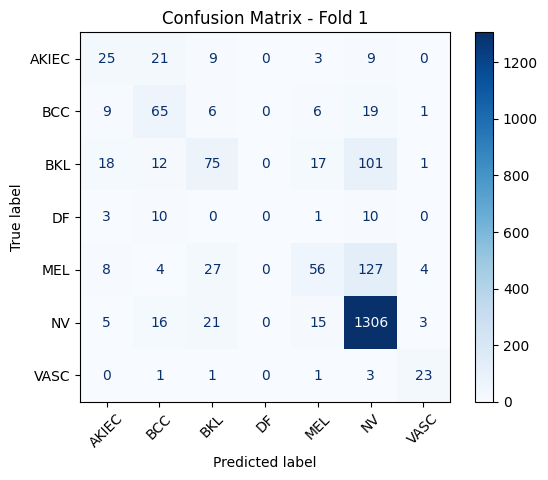

Classification Report - Fold 1
              precision    recall  f1-score   support

       AKIEC     0.3676    0.3731    0.3704        67
         BCC     0.5039    0.6132    0.5532       106
         BKL     0.5396    0.3348    0.4132       224
          DF     0.0000    0.0000    0.0000        24
         MEL     0.5657    0.2478    0.3446       226
          NV     0.8292    0.9561    0.8881      1366
        VASC     0.7188    0.7931    0.7541        29

    accuracy                         0.7591      2042
   macro avg     0.5035    0.4740    0.4748      2042
weighted avg     0.7249    0.7591    0.7292      2042

Fold 1 - Acc: 0.7591 | Prec: 0.5035 | Rec: 0.4740 | F1: 0.4748

======== Fold 2 ========
Validation loss decreased (0.8217 -> 0.8217). Saving model...
Validation loss decreased (0.8179 -> 0.8179). Saving model...
Validation loss decreased (0.7170 -> 0.7170). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Val

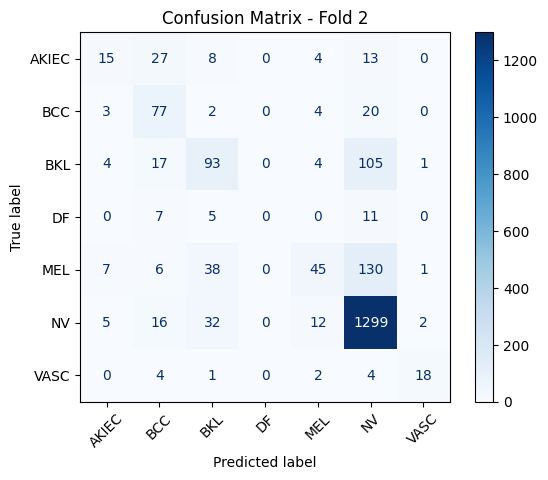

Classification Report - Fold 2
              precision    recall  f1-score   support

       AKIEC     0.4412    0.2239    0.2970        67
         BCC     0.5000    0.7264    0.5923       106
         BKL     0.5196    0.4152    0.4615       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6338    0.1982    0.3020       227
          NV     0.8211    0.9510    0.8813      1366
        VASC     0.8182    0.6207    0.7059        29

    accuracy                         0.7576      2042
   macro avg     0.5334    0.4479    0.4629      2042
weighted avg     0.7288    0.7576    0.7243      2042

Fold 2 - Acc: 0.7576 | Prec: 0.5334 | Rec: 0.4479 | F1: 0.4629

======== Fold 3 ========
Validation loss decreased (0.9606 -> 0.9606). Saving model...
Validation loss decreased (0.7892 -> 0.7892). Saving model...
Validation loss decreased (0.7660 -> 0.7660). Saving model...
Validation loss decreased (0.7621 -> 0.7621). Saving model...
Validation loss decreased (0.6719 -

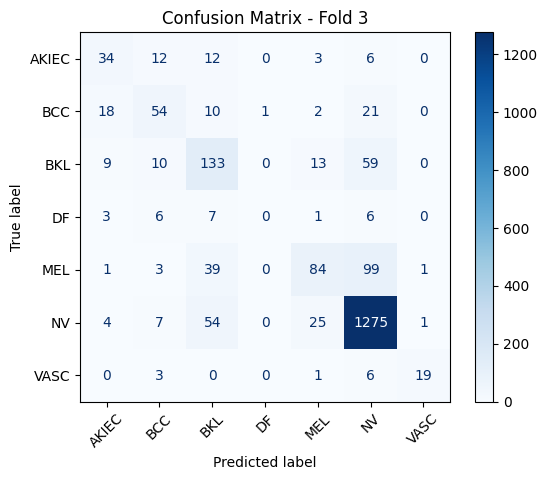

Classification Report - Fold 3
              precision    recall  f1-score   support

       AKIEC     0.4928    0.5075    0.5000        67
         BCC     0.5684    0.5094    0.5373       106
         BKL     0.5216    0.5938    0.5553       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6512    0.3700    0.4719       227
          NV     0.8662    0.9334    0.8985      1366
        VASC     0.9048    0.6552    0.7600        29

    accuracy                         0.7831      2042
   macro avg     0.5721    0.5099    0.5319      2042
weighted avg     0.7675    0.7831    0.7695      2042

Fold 3 - Acc: 0.7831 | Prec: 0.5721 | Rec: 0.5099 | F1: 0.5319

======== Fold 4 ========
Validation loss decreased (0.8527 -> 0.8527). Saving model...
Validation loss decreased (0.7718 -> 0.7718). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7606 -> 0.7606). Saving model...
Validation loss did not improve. Counter: 1/10
Val

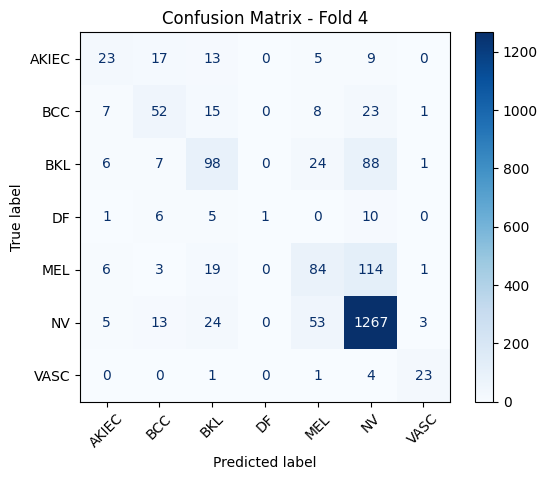

Classification Report - Fold 4
              precision    recall  f1-score   support

       AKIEC     0.4792    0.3433    0.4000        67
         BCC     0.5306    0.4906    0.5098       106
         BKL     0.5600    0.4375    0.4912       224
          DF     1.0000    0.0435    0.0833        23
         MEL     0.4800    0.3700    0.4179       227
          NV     0.8363    0.9282    0.8799      1365
        VASC     0.7931    0.7931    0.7931        29

    accuracy                         0.7585      2041
   macro avg     0.6685    0.4866    0.5107      2041
weighted avg     0.7400    0.7585    0.7407      2041

Fold 4 - Acc: 0.7585 | Prec: 0.6685 | Rec: 0.4866 | F1: 0.5107

======== Fold 5 ========
Validation loss decreased (0.7962 -> 0.7962). Saving model...
Validation loss decreased (0.7531 -> 0.7531). Saving model...
Validation loss decreased (0.7249 -> 0.7249). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6814 -> 0.6814). Savi

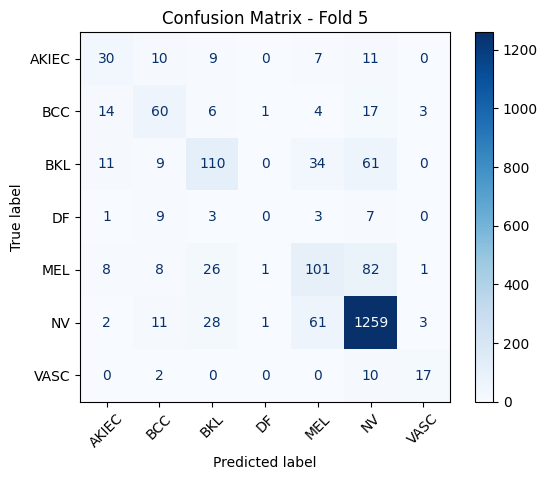

Classification Report - Fold 5
              precision    recall  f1-score   support

       AKIEC     0.4545    0.4478    0.4511        67
         BCC     0.5505    0.5714    0.5607       105
         BKL     0.6044    0.4889    0.5405       225
          DF     0.0000    0.0000    0.0000        23
         MEL     0.4810    0.4449    0.4622       227
          NV     0.8701    0.9223    0.8954      1365
        VASC     0.7083    0.5862    0.6415        29

    accuracy                         0.7727      2041
   macro avg     0.5241    0.4945    0.5074      2041
weighted avg     0.7553    0.7727    0.7626      2041

Fold 5 - Acc: 0.7727 | Prec: 0.5241 | Rec: 0.4945 | F1: 0.5074

======== Final Results ========


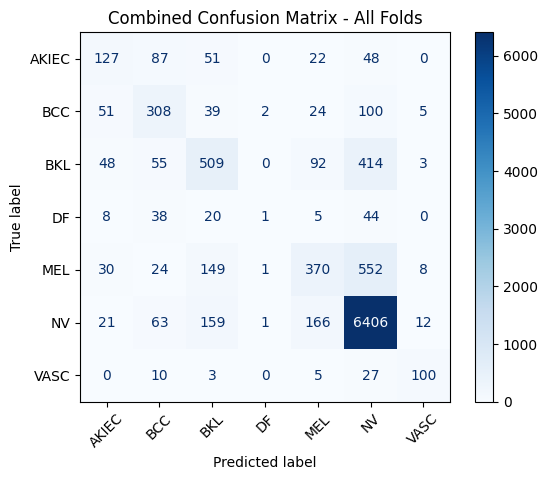

Final Classification Report:
              precision    recall  f1-score   support

       AKIEC     0.4456    0.3791    0.4097       335
         BCC     0.5265    0.5822    0.5530       529
         BKL     0.5473    0.4541    0.4963      1121
          DF     0.2000    0.0086    0.0165       116
         MEL     0.5409    0.3263    0.4070      1134
          NV     0.8439    0.9382    0.8885      6828
        VASC     0.7812    0.6897    0.7326       145

    accuracy                         0.7662     10208
   macro avg     0.5551    0.4826    0.5005     10208
weighted avg     0.7399    0.7662    0.7468     10208



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import matplotlib.pyplot as plt


data_path = r"D:\TFM\data\train_val_full"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []


for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'model_fold{fold}.pth')

    for epoch in range(50):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        if early_stopping(model, avg_val_loss):
            break

    model.load_state_dict(torch.load(f'model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4, zero_division=0))

    acc = accuracy_score(fold_labels, fold_preds)
    prec = precision_score(fold_labels, fold_preds, average='macro', zero_division=0)
    rec = recall_score(fold_labels, fold_preds, average='macro', zero_division=0)
    f1 = f1_score(fold_labels, fold_preds, average='macro', zero_division=0)
    print(f"Fold {fold+1} - Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

print("\n======== Final Results ========")
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Combined Confusion Matrix - All Folds")
plt.show()

print("Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))


Classification Report on Test Set:
              precision    recall  f1-score   support

       AKIEC     0.3000    0.2791    0.2892        43
         BCC     0.4000    0.5376    0.4587        93
         BKL     0.5665    0.5300    0.5476       217
          DF     0.0000    0.0000    0.0000        44
         MEL     0.4421    0.7368    0.5526       171
          NV     0.8304    0.5680    0.6746       250
        VASC     0.6667    0.5143    0.5806        35

    accuracy                         0.5428       853
   macro avg     0.4580    0.4523    0.4433       853
weighted avg     0.5622    0.5428    0.5362       853



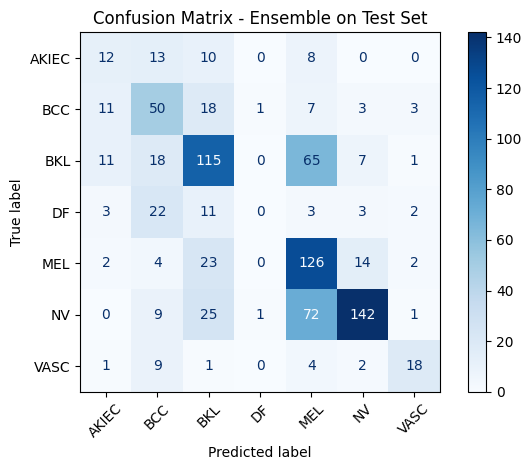

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_data_path = r"D:\TFM\data\test"  # Your test folder path
model_paths = [f"best_model_fold{i}.pth" for i in range(5)]
batch_size = 32
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

models = []
for path in model_paths:
    model = SimpleCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    models.append(model)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        ensemble_outputs = torch.zeros((inputs.size(0), num_classes), device=device)

        for model in models:
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            ensemble_outputs += probs

        ensemble_outputs /= len(models)
        preds = torch.argmax(ensemble_outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Ensemble on Test Set")
plt.tight_layout()
plt.show()



**VGG19** 


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.2102
Validation loss initialized to 1.2102. Saving model...
Epoch 2: Val Loss = 1.1051
Validation loss decreased (1.2102 -> 1.1051). Saving model...
Epoch 3: Val Loss = 1.1321
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 1.0975
Validation loss decreased (1.1051 -> 1.0975). Saving model...
Epoch 5: Val Loss = 1.3070
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 1.2195
Validation loss did not improve. Counter: 2/10
Epoch 7: Val Loss = 1.1172
Validation loss did not improve. Counter: 3/10
Epoch 8: Val Loss = 1.1647
Validation loss did not improve. Counter: 4/10
Epoch 9: Val Loss = 1.0592
Validation loss decreased (1.0975 -> 1.0592). Saving model...
Epoch 10: Val Loss = 1.2454
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 1.0939
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 1.1190
Validation loss did not improve. Counter: 3/10
Epoch 13: Val Loss = 1.1440
Validation loss did not impr

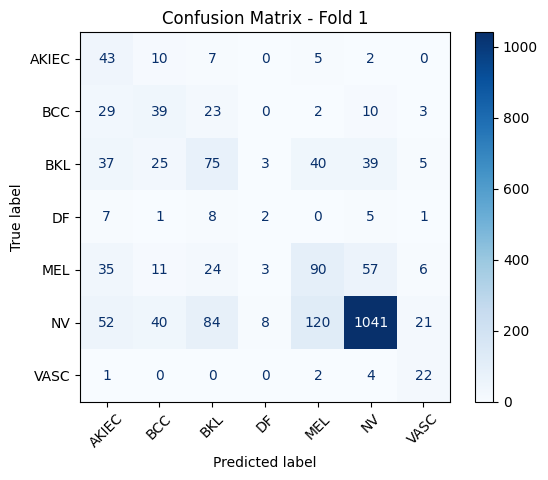


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.3411
Validation loss initialized to 1.3411. Saving model...
Epoch 2: Val Loss = 1.1044
Validation loss decreased (1.3411 -> 1.1044). Saving model...
Epoch 3: Val Loss = 1.1985
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 1.1311
Validation loss did not improve. Counter: 2/10
Epoch 5: Val Loss = 1.1196
Validation loss did not improve. Counter: 3/10
Epoch 6: Val Loss = 1.1734
Validation loss did not improve. Counter: 4/10
Epoch 7: Val Loss = 1.1007
Validation loss decreased (1.1044 -> 1.1007). Saving model...
Epoch 8: Val Loss = 1.1545
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 1.1695
Validation loss did not improve. Counter: 2/10
Epoch 10: Val Loss = 1.1433
Validation loss did not improve. Counter: 3/10
Epoch 11: Val Loss = 1.0587
Validation loss decreased (1.1007 -> 1.0587). Saving model...
Epoch 12: Val Loss = 1.4619
Validation loss did not improve. Counter: 1/10
Epoch 13: Val Loss = 1.3220
Validation loss did not impr

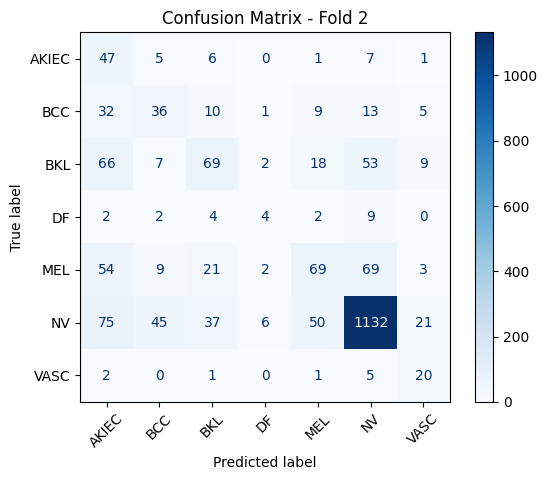


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.3819
Validation loss initialized to 1.3819. Saving model...
Epoch 2: Val Loss = 1.4229
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 1.4744
Validation loss did not improve. Counter: 2/10
Epoch 4: Val Loss = 1.3088
Validation loss decreased (1.3819 -> 1.3088). Saving model...
Epoch 5: Val Loss = 1.2910
Validation loss decreased (1.3088 -> 1.2910). Saving model...
Epoch 6: Val Loss = 1.5454
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 1.3053
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 1.2793
Validation loss decreased (1.2910 -> 1.2793). Saving model...
Epoch 9: Val Loss = 1.0763
Validation loss decreased (1.2793 -> 1.0763). Saving model...
Epoch 10: Val Loss = 1.1669
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 1.2056
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 1.1065
Validation loss did not improve. Counter: 3/10
Epoch 13: Val Loss = 1.2524
Validation lo

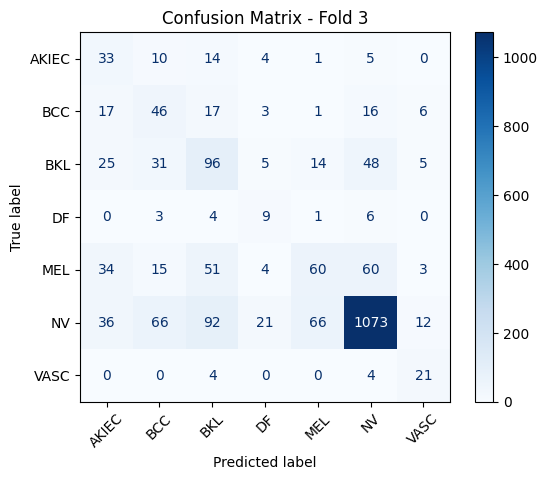


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.2948
Validation loss initialized to 1.2948. Saving model...
Epoch 2: Val Loss = 1.4073
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 1.2463
Validation loss decreased (1.2948 -> 1.2463). Saving model...
Epoch 4: Val Loss = 1.2792
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 1.0988
Validation loss decreased (1.2463 -> 1.0988). Saving model...
Epoch 6: Val Loss = 1.0585
Validation loss decreased (1.0988 -> 1.0585). Saving model...
Epoch 7: Val Loss = 1.1397
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 1.2088
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 1.3771
Validation loss did not improve. Counter: 3/10
Epoch 10: Val Loss = 1.3122
Validation loss did not improve. Counter: 4/10
Epoch 11: Val Loss = 1.3265
Validation loss did not improve. Counter: 5/10
Epoch 12: Val Loss = 1.1269
Validation loss did not improve. Counter: 6/10
Epoch 13: Val Loss = 1.1749
Validation loss did not impr

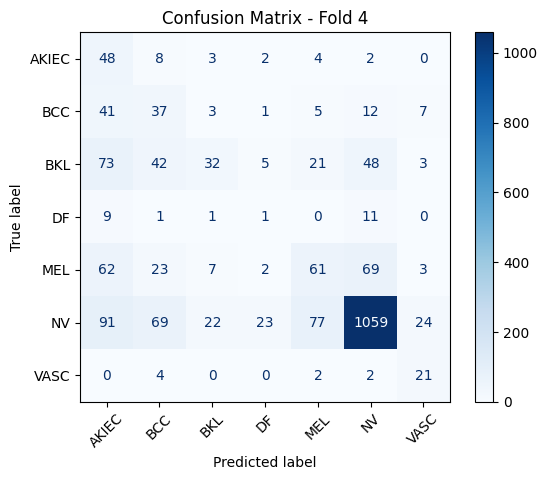


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.3650
Validation loss initialized to 1.3650. Saving model...
Epoch 2: Val Loss = 1.4950
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 1.2144
Validation loss decreased (1.3650 -> 1.2144). Saving model...
Epoch 4: Val Loss = 1.4974
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 1.1399
Validation loss decreased (1.2144 -> 1.1399). Saving model...
Epoch 6: Val Loss = 1.2401
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 1.4378
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 1.2632
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 1.2926
Validation loss did not improve. Counter: 4/10
Epoch 10: Val Loss = 1.2641
Validation loss did not improve. Counter: 5/10
Epoch 11: Val Loss = 1.0930
Validation loss decreased (1.1399 -> 1.0930). Saving model...
Epoch 12: Val Loss = 1.2291
Validation loss did not improve. Counter: 1/10
Epoch 13: Val Loss = 1.2060
Validation loss did not impr

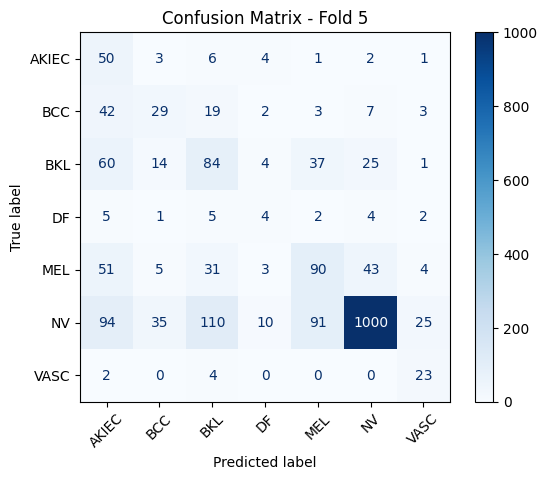


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.1761    0.6597    0.2780       335
         BCC     0.2783    0.3535    0.3114       529
         BKL     0.3655    0.3176    0.3399      1121
          DF     0.1449    0.1724    0.1575       116
         MEL     0.3911    0.3263    0.3558      1134
          NV     0.8928    0.7769    0.8309      6828
        VASC     0.3808    0.7379    0.5023       145

    accuracy                         0.6432     10208
   macro avg     0.3756    0.4778    0.3965     10208
weighted avg     0.7080    0.6432    0.6668     10208



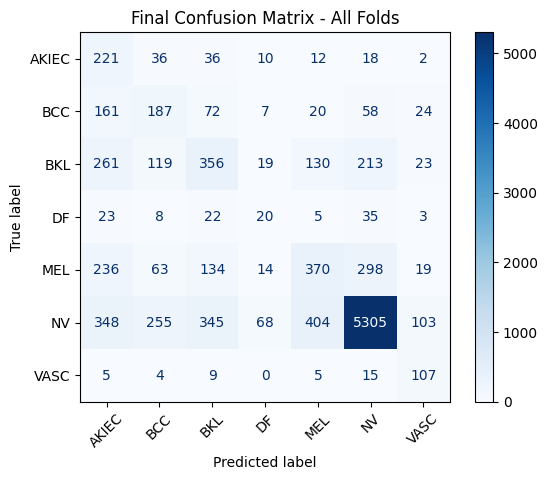

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 0.001
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
    weights = torch.FloatTensor(weights).to(device)

    print("Class Weights (Fold {}):".format(fold+1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")

    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze feature extractor

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # ===== Load Best Model =====
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))

    # ===== Final Validation Predictions =====
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    # ===== Classification Report =====
    print(f"\nClassification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

# ===================== FINAL REPORT =====================
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()


Evaluando modelo fold 0 en el test set...


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluando modelo fold 1 en el test set...
Evaluando modelo fold 2 en el test set...
Evaluando modelo fold 3 en el test set...
Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (Ensamble de 5 Folds con VGG19) ========
              precision    recall  f1-score   support

       AKIEC     0.0455    0.1628    0.0711        43
         BCC     0.1298    0.3978    0.1958        93
         BKL     0.2903    0.0415    0.0726       217
          DF     0.0000    0.0000    0.0000        44
         MEL     0.1542    0.8538    0.2612       171
          NV     0.9701    0.0715    0.1332       909
        VASC     0.3333    0.2571    0.2903        35

    accuracy                         0.1806      1512
   macro avg     0.2748    0.2549    0.1463      1512
weighted avg     0.6593    0.1806    0.1408      1512



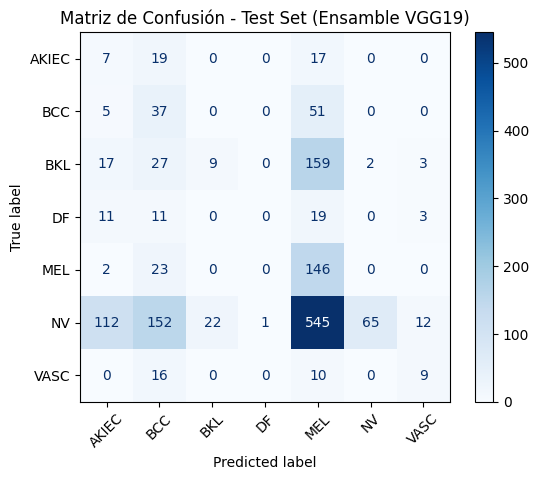

In [37]:
# ===================== TEST SET EVALUATION (VGG19 Ensemble) =====================
test_data_path = r"D:\TFM\ISIC2018\test"
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_labels = [label for _, label in test_dataset]

all_test_preds = []

for fold in range(k_folds):
    print(f"Evaluando modelo fold {fold} en el test set...")

    # Cargar modelo VGG19
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Congelar capa base

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model = model.to(device)
    
    # Cargar pesos del mejor modelo para este fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.append(preds.cpu().numpy())

    all_test_preds.append(np.concatenate(fold_preds))

# ===================== ENSEMBLE PREDICTION =====================
all_test_preds = np.array(all_test_preds)  # Shape: (5, num_samples)

# Votación mayoritaria entre modelos
ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_test_preds)

# ===================== REPORT =====================
print("\n======== Resultados del Test Set (Ensamble de 5 Folds con VGG19) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))

cm_test_ensemble = confusion_matrix(test_labels, ensemble_preds)
disp_test_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_test_ensemble, display_labels=class_names)
disp_test_ensemble.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Ensamble VGG19)")
plt.show()

**INCEPTION**


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Ander/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 95.0MB/s] 


Epoch 1: Val Loss = 1.2955
Validation loss initialized to 1.2955. Saving model...
Epoch 2: Val Loss = 1.4558
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 1.1313
Validation loss decreased (1.2955 -> 1.1313). Saving model...
Epoch 4: Val Loss = 1.0062
Validation loss decreased (1.1313 -> 1.0062). Saving model...
Epoch 5: Val Loss = 0.9953
Validation loss decreased (1.0062 -> 0.9953). Saving model...
Epoch 6: Val Loss = 1.2289
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 1.0699
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 1.1640
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 0.8494
Validation loss decreased (0.9953 -> 0.8494). Saving model...
Epoch 10: Val Loss = 1.0823
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 1.1060
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 0.8889
Validation loss did not improve. Counter: 3/10
Epoch 13: Val Loss = 1.0114
Validation lo

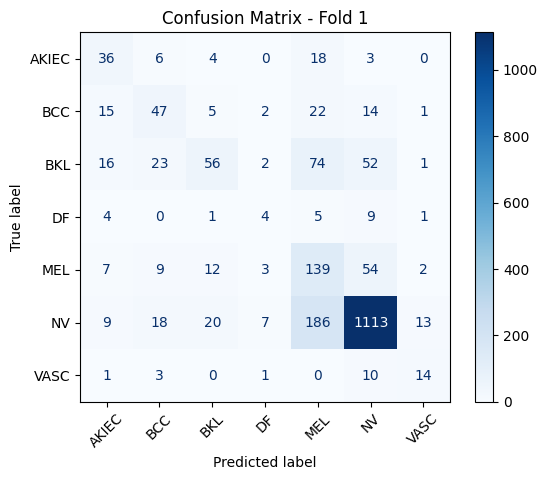


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.2998
Validation loss initialized to 1.2998. Saving model...
Epoch 2: Val Loss = 1.1533
Validation loss decreased (1.2998 -> 1.1533). Saving model...
Epoch 3: Val Loss = 1.0913
Validation loss decreased (1.1533 -> 1.0913). Saving model...
Epoch 4: Val Loss = 1.2640
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 1.0612
Validation loss decreased (1.0913 -> 1.0612). Saving model...
Epoch 6: Val Loss = 1.1688
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.9617
Validation loss decreased (1.0612 -> 0.9617). Saving model...
Epoch 8: Val Loss = 0.9840
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 1.2088
Validation loss did not improve. Counter: 2/10
Epoch 10: Val Loss = 0.9885
Validation loss did not improve. Counter: 3/10
Epoch 11: Val Loss = 1.0520
Validation loss did not improve. Counter: 4/10
Epoch 12: Val Loss = 1.0114
Validation loss did not improve. Counter: 5/10
Epoch 13: Val Loss = 1.2119
Validation lo

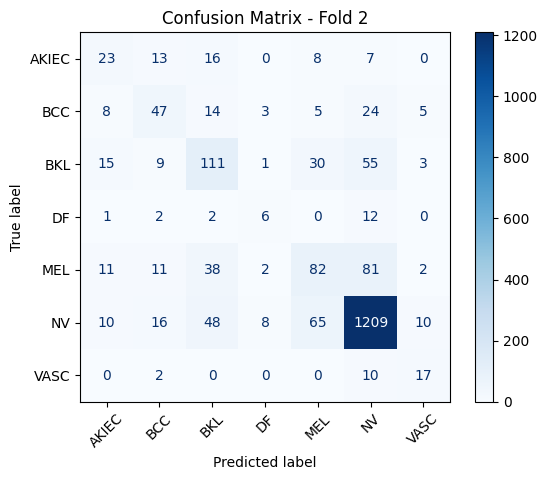


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.4261
Validation loss initialized to 1.4261. Saving model...
Epoch 2: Val Loss = 1.2439
Validation loss decreased (1.4261 -> 1.2439). Saving model...
Epoch 3: Val Loss = 1.1534
Validation loss decreased (1.2439 -> 1.1534). Saving model...
Epoch 4: Val Loss = 1.1218
Validation loss decreased (1.1534 -> 1.1218). Saving model...
Epoch 5: Val Loss = 1.2263
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 1.0698
Validation loss decreased (1.1218 -> 1.0698). Saving model...
Epoch 7: Val Loss = 1.0487
Validation loss decreased (1.0698 -> 1.0487). Saving model...
Epoch 8: Val Loss = 1.0508
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.9139
Validation loss decreased (1.0487 -> 0.9139). Saving model...
Epoch 10: Val Loss = 1.1463
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 1.0914
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 1.0404
Validation loss did not improve. Counter: 3/10
Epoch 13: V

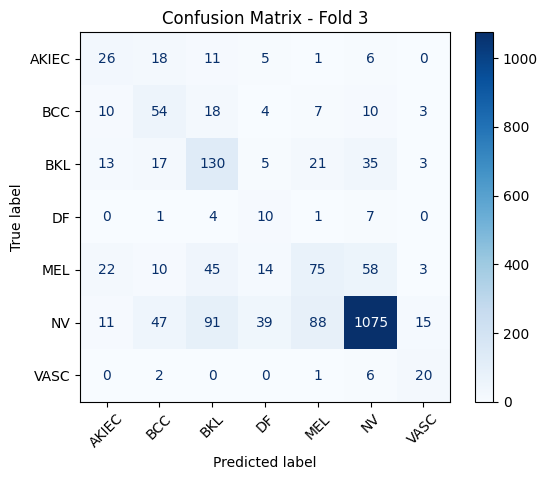


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.3236
Validation loss initialized to 1.3236. Saving model...
Epoch 2: Val Loss = 1.0541
Validation loss decreased (1.3236 -> 1.0541). Saving model...
Epoch 3: Val Loss = 1.0347
Validation loss decreased (1.0541 -> 1.0347). Saving model...
Epoch 4: Val Loss = 1.0167
Validation loss decreased (1.0347 -> 1.0167). Saving model...
Epoch 5: Val Loss = 1.1237
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 1.0953
Validation loss did not improve. Counter: 2/10
Epoch 7: Val Loss = 0.9254
Validation loss decreased (1.0167 -> 0.9254). Saving model...
Epoch 8: Val Loss = 0.9447
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 1.0748
Validation loss did not improve. Counter: 2/10
Epoch 10: Val Loss = 0.9374
Validation loss did not improve. Counter: 3/10
Epoch 11: Val Loss = 1.1138
Validation loss did not improve. Counter: 4/10
Epoch 12: Val Loss = 1.0164
Validation loss did not improve. Counter: 5/10
Epoch 13: Val Loss = 0.9786
Validation lo

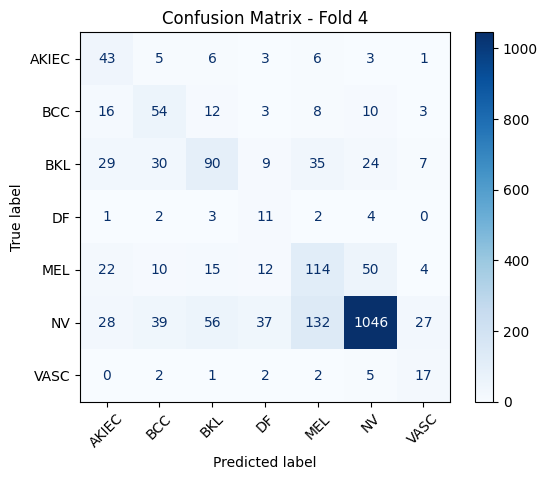


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.1958
Validation loss initialized to 1.1958. Saving model...
Epoch 2: Val Loss = 1.2098
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 0.9656
Validation loss decreased (1.1958 -> 0.9656). Saving model...
Epoch 4: Val Loss = 1.2163
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 1.1083
Validation loss did not improve. Counter: 2/10
Epoch 6: Val Loss = 0.9304
Validation loss decreased (0.9656 -> 0.9304). Saving model...
Epoch 7: Val Loss = 0.9673
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 1.1370
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.9891
Validation loss did not improve. Counter: 3/10
Epoch 10: Val Loss = 1.0306
Validation loss did not improve. Counter: 4/10
Epoch 11: Val Loss = 1.0291
Validation loss did not improve. Counter: 5/10
Epoch 12: Val Loss = 0.9455
Validation loss did not improve. Counter: 6/10
Epoch 13: Val Loss = 1.0358
Validation loss did not improve. Counter: 7

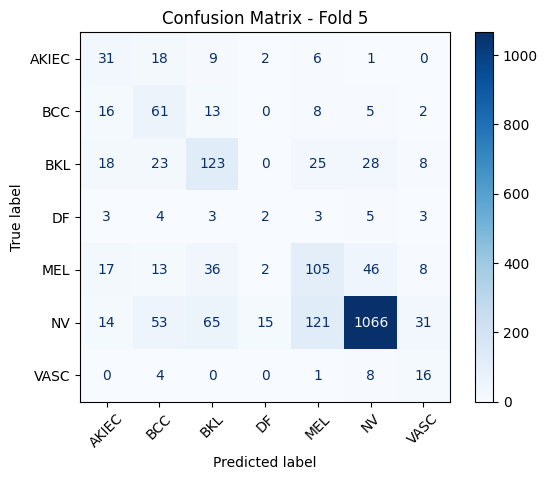


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.3340    0.4746    0.3921       335
         BCC     0.3908    0.4972    0.4376       529
         BKL     0.4820    0.4550    0.4681      1121
          DF     0.1542    0.2845    0.2000       116
         MEL     0.3689    0.4541    0.4071      1134
          NV     0.8956    0.8068    0.8489      6828
        VASC     0.3500    0.5793    0.4364       145

    accuracy                         0.6929     10208
   macro avg     0.4251    0.5074    0.4557     10208
weighted avg     0.7309    0.6929    0.7085     10208



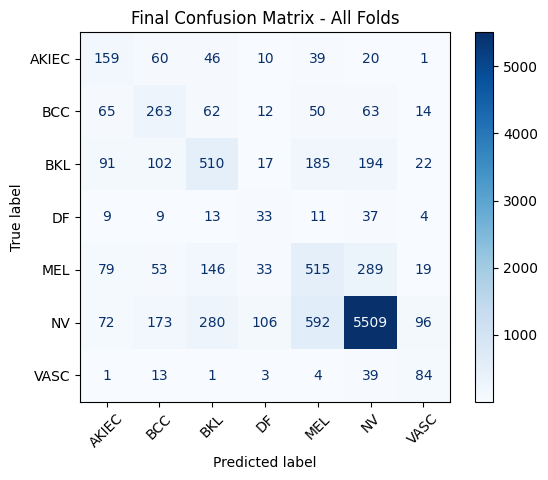

In [ ]:
data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 0.001
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # ===== Class Weights =====
    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
    weights = torch.FloatTensor(weights).to(device)

    print("Class Weights (Fold {}):".format(fold+1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")

    model = models.inception_v3(pretrained=True, aux_logits=True)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))

    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()



======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 2.6639
Validation loss initialized to 2.6639. Saving model...
Epoch 2: Val Loss = 2.0104
Validation loss decreased (2.6639 -> 2.0104). Saving model...
Epoch 3: Val Loss = 1.0909
Validation loss decreased (2.0104 -> 1.0909). Saving model...
Epoch 4: Val Loss = 0.8189
Validation loss decreased (1.0909 -> 0.8189). Saving model...
Epoch 5: Val Loss = 1.7602
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.6387
Validation loss decreased (0.8189 -> 0.6387). Saving model...
Epoch 7: Val Loss = 1.0730
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.7868
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.6859
Validation loss did not improve. Counter: 3/10
Epoch 10: Val Loss = 0.8393
Validation loss did not improve. Counter: 4/10
Epoch 11: Val Loss = 0.6176
Validation loss decreased (0.6387 -> 0.6176). Saving model...
Epoch 12: Val Loss = 0.6340
Validation loss did not improve. Counter: 1/10
Epoch 13: Val Loss = 0.649

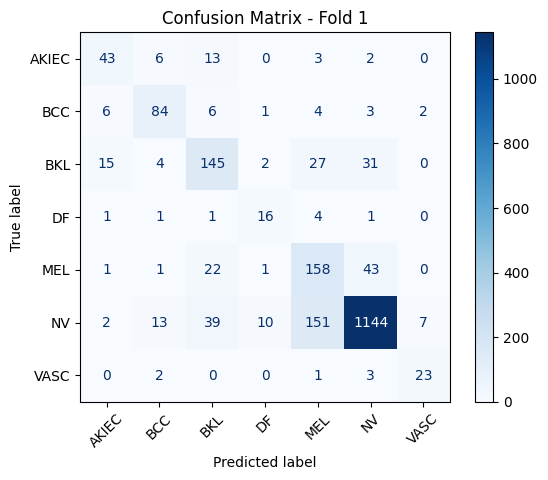


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.2046
Validation loss initialized to 1.2046. Saving model...
Epoch 2: Val Loss = 1.7205
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 0.7100
Validation loss decreased (1.2046 -> 0.7100). Saving model...
Epoch 4: Val Loss = 0.7868
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.8682
Validation loss did not improve. Counter: 2/10
Epoch 6: Val Loss = 0.7113
Validation loss did not improve. Counter: 3/10
Epoch 7: Val Loss = 0.7458
Validation loss did not improve. Counter: 4/10
Epoch 8: Val Loss = 0.6263
Validation loss decreased (0.7100 -> 0.6263). Saving model...
Epoch 9: Val Loss = 0.5747
Validation loss decreased (0.6263 -> 0.5747). Saving model...
Epoch 10: Val Loss = 0.6167
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 0.6093
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 0.5935
Validation loss did not improve. Counter: 3/10
Epoch 13: Val Loss = 0.6132
Validation loss did not impr

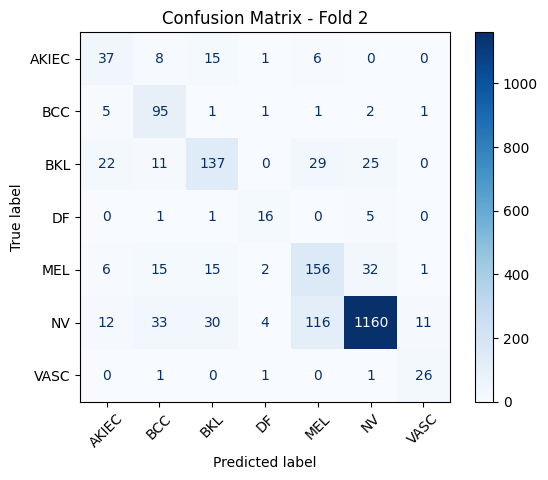


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 1.2409
Validation loss initialized to 1.2409. Saving model...
Epoch 2: Val Loss = 0.7480
Validation loss decreased (1.2409 -> 0.7480). Saving model...
Epoch 3: Val Loss = 1.0801
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 1.1265
Validation loss did not improve. Counter: 2/10
Epoch 5: Val Loss = 0.9115
Validation loss did not improve. Counter: 3/10
Epoch 6: Val Loss = 0.7543
Validation loss did not improve. Counter: 4/10
Epoch 7: Val Loss = 0.6774
Validation loss decreased (0.7480 -> 0.6774). Saving model...
Epoch 8: Val Loss = 0.6629
Validation loss decreased (0.6774 -> 0.6629). Saving model...
Epoch 9: Val Loss = 0.6065
Validation loss decreased (0.6629 -> 0.6065). Saving model...
Epoch 10: Val Loss = 0.6596
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 0.6472
Validation loss did not improve. Counter: 2/10
Epoch 12: Val Loss = 0.6738
Validation loss did not improve. Counter: 3/10
Epoch 13: Val Loss = 0.6811
Validation lo

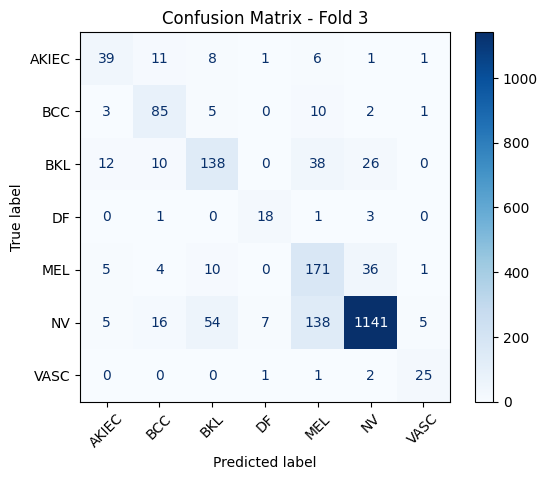


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.9966
Validation loss initialized to 0.9966. Saving model...
Epoch 2: Val Loss = 3.5693
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 0.9706
Validation loss decreased (0.9966 -> 0.9706). Saving model...
Epoch 4: Val Loss = 0.7923
Validation loss decreased (0.9706 -> 0.7923). Saving model...
Epoch 5: Val Loss = 0.9502
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.9893
Validation loss did not improve. Counter: 2/10
Epoch 7: Val Loss = 0.7417
Validation loss decreased (0.7923 -> 0.7417). Saving model...
Epoch 8: Val Loss = 0.8550
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 1.0502
Validation loss did not improve. Counter: 2/10
Epoch 10: Val Loss = 0.8630
Validation loss did not improve. Counter: 3/10
Epoch 11: Val Loss = 0.8097
Validation loss did not improve. Counter: 4/10
Epoch 12: Val Loss = 0.7004
Validation loss decreased (0.7417 -> 0.7004). Saving model...
Epoch 13: Val Loss = 0.6547
Validation lo

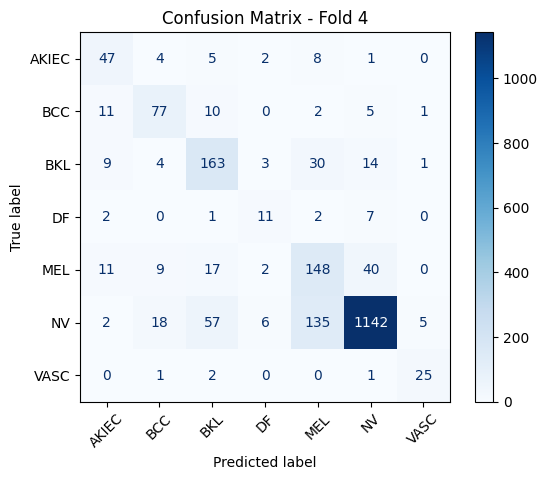


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579


C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.9808
Validation loss initialized to 0.9808. Saving model...
Epoch 2: Val Loss = 0.9243
Validation loss decreased (0.9808 -> 0.9243). Saving model...
Epoch 3: Val Loss = 0.8478
Validation loss decreased (0.9243 -> 0.8478). Saving model...
Epoch 4: Val Loss = 0.8096
Validation loss decreased (0.8478 -> 0.8096). Saving model...
Epoch 5: Val Loss = 1.0583
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.6827
Validation loss decreased (0.8096 -> 0.6827). Saving model...
Epoch 7: Val Loss = 0.7808
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.6867
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.6883
Validation loss did not improve. Counter: 3/10
Epoch 10: Val Loss = 0.7694
Validation loss did not improve. Counter: 4/10
Epoch 11: Val Loss = 0.6394
Validation loss decreased (0.6827 -> 0.6394). Saving model...
Epoch 12: Val Loss = 0.6223
Validation loss decreased (0.6394 -> 0.6223). Saving model...
Epoch 13: V

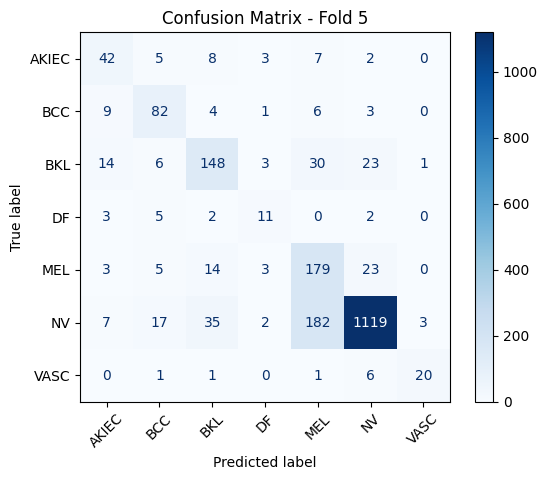


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.5561    0.6209    0.5867       335
         BCC     0.6651    0.7996    0.7262       529
         BKL     0.6603    0.6521    0.6562      1121
          DF     0.5581    0.6207    0.5878       116
         MEL     0.4637    0.7160    0.5629      1134
          NV     0.9430    0.8357    0.8861      6828
        VASC     0.7438    0.8207    0.7803       145

    accuracy                         0.7907     10208
   macro avg     0.6557    0.7237    0.6837     10208
weighted avg     0.8244    0.7907    0.8019     10208

Final Balanced Accuracy: 0.7237


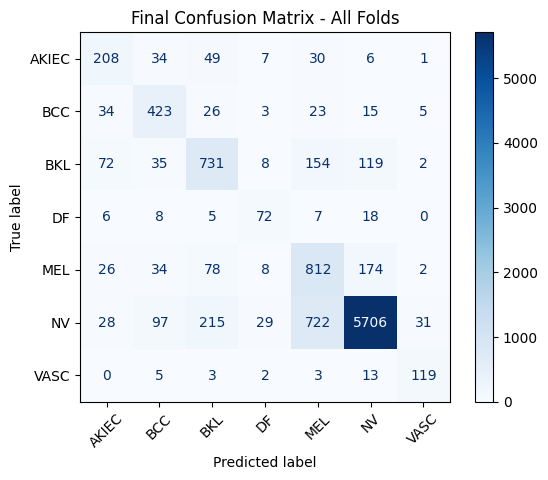

In [53]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import Counter

# Configuración
data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 0.001
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset base
base_dataset = datasets.ImageFolder(root=data_path)
targets = np.array(base_dataset.targets)
class_names = base_dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_train), train_idx)
    val_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_val), val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Class weights
    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
    weights = torch.FloatTensor(weights).to(device)

    print("Class Weights (Fold {}):".format(fold+1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")

    # Modelo
    model = models.inception_v3(pretrained=True, aux_logits=True)
    for name, param in model.named_parameters():
        if "fc" in name or "AuxLogits" in name or "Mixed_7" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    model = model.to(device)

    # Pérdida y optimizador
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # Evaluación del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))
    print(f"Balanced Accuracy: {balanced_accuracy_score(fold_labels, fold_preds):.4f}")

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

# Resultados Finales
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()


Evaluando modelo fold 0 en el test set...
Evaluando modelo fold 1 en el test set...
Evaluando modelo fold 2 en el test set...
Evaluando modelo fold 3 en el test set...
Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (Inception Ensamble) ========
              precision    recall  f1-score   support

       AKIEC     0.3165    0.5814    0.4098        43
         BCC     0.4597    0.6129    0.5253        93
         BKL     0.5514    0.4700    0.5075       217
          DF     0.4848    0.3636    0.4156        44
         MEL     0.3835    0.4620    0.4191       171
          NV     0.8610    0.8108    0.8351       909
        VASC     0.4828    0.4000    0.4375        35

    accuracy                         0.6812      1512
   macro avg     0.5057    0.5287    0.5071      1512
weighted avg     0.7027    0.6812    0.6885      1512



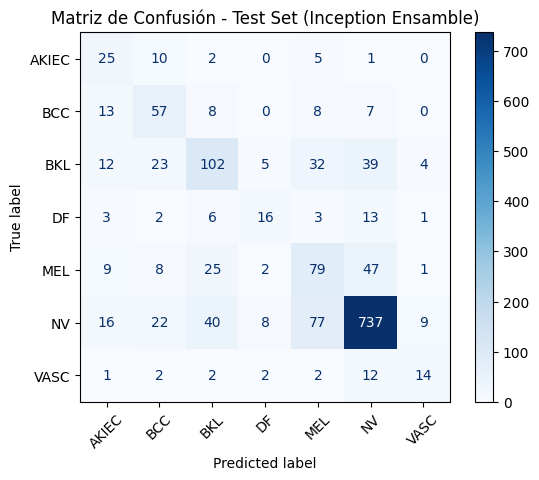

In [41]:
from torchvision.models import Inception_V3_Weights

all_test_preds = []

for fold in range(k_folds):
    print(f"Evaluando modelo fold {fold} en el test set...")

    # Cargar modelo con las mismas modificaciones que durante entrenamiento
    model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    model.aux_logits = False  # Evitamos la salida auxiliar durante test
    model = model.to(device)

    # Cargar los pesos entrenados
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Solo devuelve la salida principal
            preds = outputs.argmax(dim=1)
            fold_preds.append(preds.cpu().numpy())

    all_test_preds.append(np.concatenate(fold_preds))

# Ensemble
all_test_preds = np.array(all_test_preds)
ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_test_preds)

print("\n======== Resultados del Test Set (Inception Ensamble) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))

cm_test_ensemble = confusion_matrix(test_labels, ensemble_preds)
disp_test_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_test_ensemble, display_labels=class_names)
disp_test_ensemble.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Inception Ensamble)")
plt.show()



Evaluando modelo fold 0 en el test set (softmax)...

Evaluando modelo fold 1 en el test set (softmax)...

Evaluando modelo fold 2 en el test set (softmax)...

Evaluando modelo fold 3 en el test set (softmax)...

Evaluando modelo fold 4 en el test set (softmax)...

======== Resultados - Ensemble Promedio Softmax ========
              precision    recall  f1-score   support

       AKIEC     0.4211    0.5581    0.4800        43
         BCC     0.6250    0.7527    0.6829        93
         BKL     0.7347    0.6636    0.6973       217
          DF     0.6923    0.6136    0.6506        44
         MEL     0.4224    0.5731    0.4864       171
          NV     0.9020    0.8405    0.8702       909
        VASC     0.6207    0.5143    0.5625        35

    accuracy                         0.7573      1512
   macro avg     0.6312    0.6451    0.6328      1512
weighted avg     0.7804    0.7573    0.7658      1512

Balanced Accuracy: 0.6451


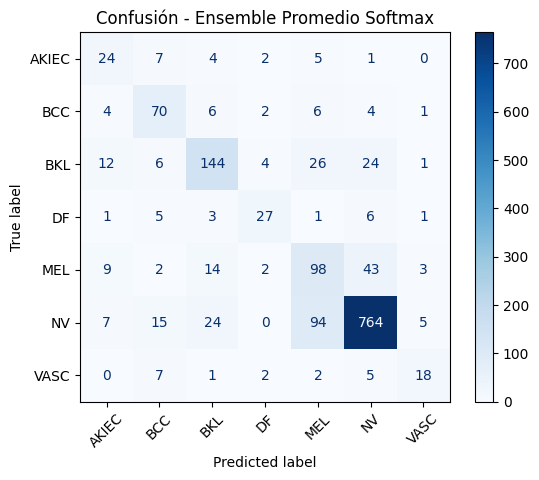

In [54]:
from torchvision.models import Inception_V3_Weights

# Dataset de test
test_path = r"D:\TFM\ISIC2018\test"
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_labels = [label for _, label in test_dataset]

# Ensemble softmax
all_fold_probs = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set (softmax)...")

    model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    model.aux_logits = False
    model = model.to(device)
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            fold_probs.append(probs.cpu().numpy())

    all_fold_probs.append(np.concatenate(fold_probs))

# Promediar probabilidades
avg_probs = np.mean(np.array(all_fold_probs), axis=0)
ensemble_preds_softmax = np.argmax(avg_probs, axis=1)

# Evaluación
print("\n======== Resultados - Ensemble Promedio Softmax ========")
print(classification_report(test_labels, ensemble_preds_softmax, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds_softmax):.4f}")

cm_softmax = confusion_matrix(test_labels, ensemble_preds_softmax)
disp_softmax = ConfusionMatrixDisplay(confusion_matrix=cm_softmax, display_labels=class_names)
disp_softmax.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusión - Ensemble Promedio Softmax")
plt.show()



Evaluando modelo fold 0 en el test set (voto mayoritario)...

Evaluando modelo fold 1 en el test set (voto mayoritario)...

Evaluando modelo fold 2 en el test set (voto mayoritario)...

Evaluando modelo fold 3 en el test set (voto mayoritario)...

Evaluando modelo fold 4 en el test set (voto mayoritario)...

======== Resultados - Ensemble Voto Mayoritario ========
              precision    recall  f1-score   support

       AKIEC     0.3770    0.5349    0.4423        43
         BCC     0.6250    0.7527    0.6829        93
         BKL     0.7143    0.6452    0.6780       217
          DF     0.6750    0.6136    0.6429        44
         MEL     0.4242    0.5731    0.4876       171
          NV     0.9006    0.8372    0.8677       909
        VASC     0.5556    0.4286    0.4839        35

    accuracy                         0.7500      1512
   macro avg     0.6102    0.6265    0.6122      1512
weighted avg     0.7736    0.7500    0.7586      1512

Balanced Accuracy: 0.6265


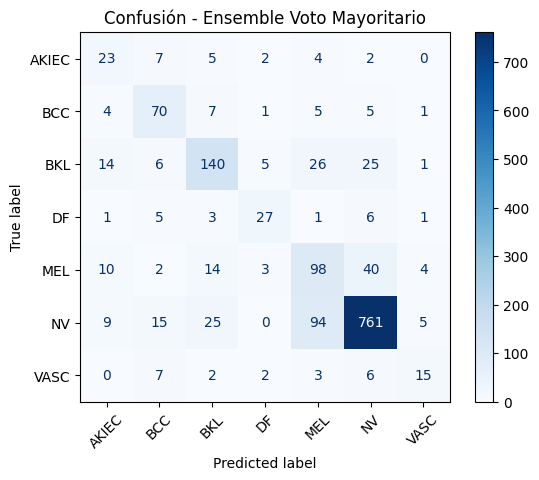

In [55]:
# Ensemble por voto
all_test_preds = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set (voto mayoritario)...")

    model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    model.aux_logits = False
    model = model.to(device)
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.append(preds.cpu().numpy())

    all_test_preds.append(np.concatenate(fold_preds))

all_test_preds = np.array(all_test_preds)
ensemble_preds_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_test_preds)

# Evaluación
print("\n======== Resultados - Ensemble Voto Mayoritario ========")
print(classification_report(test_labels, ensemble_preds_majority, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds_majority):.4f}")

cm_majority = confusion_matrix(test_labels, ensemble_preds_majority)
disp_majority = ConfusionMatrixDisplay(confusion_matrix=cm_majority, display_labels=class_names)
disp_majority.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusión - Ensemble Voto Mayoritario")
plt.show()

In [56]:
from sklearn.metrics import accuracy_score

print("\n======== Comparación de Métodos de Ensemble ========")
print("→ Voto Mayoritario - Accuracy:", accuracy_score(test_labels, ensemble_preds_majority))
print("→ Softmax Promedio   - Accuracy:", accuracy_score(test_labels, ensemble_preds_softmax))
print("→ Voto Mayoritario - Balanced Accuracy:", balanced_accuracy_score(test_labels, ensemble_preds_majority))
print("→ Softmax Promedio   - Balanced Accuracy:", balanced_accuracy_score(test_labels, ensemble_preds_softmax))


======== Comparación de Métodos de Ensemble ========
→ Voto Mayoritario - Accuracy: 0.75
→ Softmax Promedio   - Accuracy: 0.7572751322751323
→ Voto Mayoritario - Balanced Accuracy: 0.6264605870114474
→ Softmax Promedio   - Balanced Accuracy: 0.6451325312149159


**Efficientnet**


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 1.0417
Validation loss initialized to 1.0417. Saving model...
Epoch 2: Val Loss = 0.8603
Validation loss decreased (1.0417 -> 0.8603). Saving model...
Epoch 3: Val Loss = 0.8926
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 0.8612
Validation loss did not improve. Counter: 2/10
Epoch 5: Val Loss = 0.8120
Validation loss decreased (0.8603 -> 0.8120). Saving model...
Epoch 6: Val Loss = 0.7760
Validation loss decreased (0.8120 -> 0.7760). Saving model...
Epoch 7: Val Loss = 0.8149
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.8145
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.7626
Validation loss decreased (0.7760 -> 0.7626). Saving model

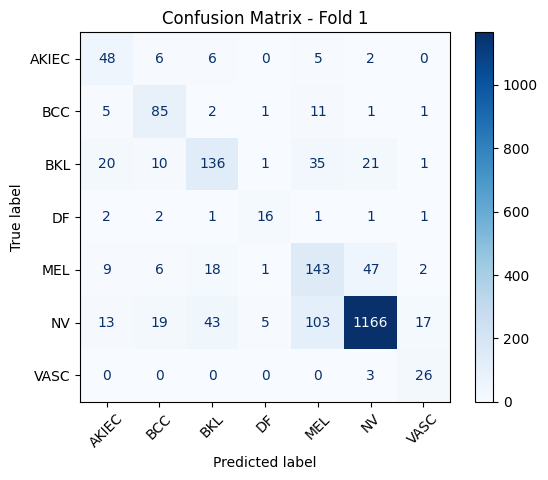


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 0.8721
Validation loss initialized to 0.8721. Saving model...
Epoch 2: Val Loss = 0.8103
Validation loss decreased (0.8721 -> 0.8103). Saving model...
Epoch 3: Val Loss = 0.7259
Validation loss decreased (0.8103 -> 0.7259). Saving model...
Epoch 4: Val Loss = 0.7598
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.7280
Validation loss did not improve. Counter: 2/10
Epoch 6: Val Loss = 0.7292
Validation loss did not improve. Counter: 3/10
Epoch 7: Val Loss = 0.6719
Validation loss decreased (0.7259 -> 0.6719). Saving model...
Epoch 8: Val Loss = 0.6711
Validation loss decreased (0.6719 -> 0.6711). Saving model...
Epoch 9: Val Loss = 0.6374
Validation loss decreased (0.6711 -> 0.6374

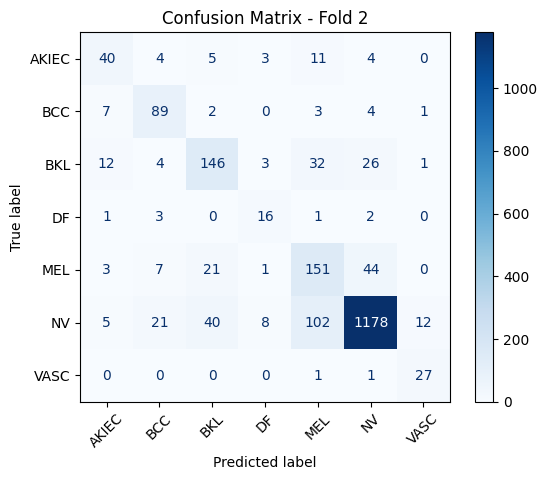


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 0.8676
Validation loss initialized to 0.8676. Saving model...
Epoch 2: Val Loss = 0.8597
Validation loss decreased (0.8676 -> 0.8597). Saving model...
Epoch 3: Val Loss = 0.8337
Validation loss decreased (0.8597 -> 0.8337). Saving model...
Epoch 4: Val Loss = 0.8497
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.7927
Validation loss decreased (0.8337 -> 0.7927). Saving model...
Epoch 6: Val Loss = 0.7817
Validation loss decreased (0.7927 -> 0.7817). Saving model...
Epoch 7: Val Loss = 0.8120
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.7347
Validation loss decreased (0.7817 -> 0.7347). Saving model...
Epoch 9: Val Loss = 0.7378
Validation loss did not impr

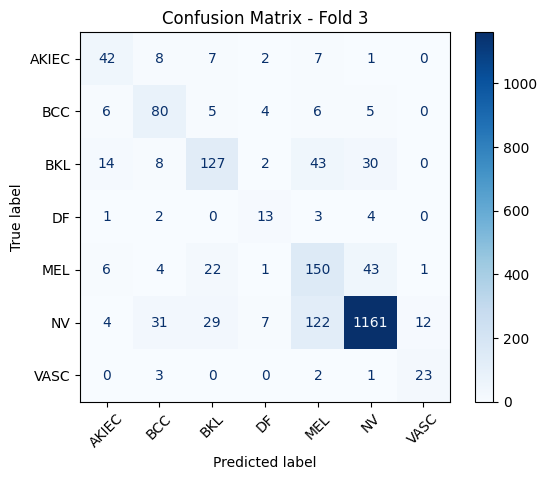


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Epoch 1: Val Loss = 1.0120
Validation loss initialized to 1.0120. Saving model...
Epoch 2: Val Loss = 0.8325
Validation loss decreased (1.0120 -> 0.8325). Saving model...
Epoch 3: Val Loss = 0.8158
Validation loss decreased (0.8325 -> 0.8158). Saving model...
Epoch 4: Val Loss = 0.8376
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.7744
Validation loss decreased (0.8158 -> 0.7744). Saving model...
Epoch 6: Val Loss = 0.6666
Validation loss decreased (0.7744 -> 0.6666). Saving model...
Epoch 7: Val Loss = 0.6494
Validation loss decreased (0.6666 -> 0.6494). Saving model...
Epoch 8: Val Loss = 0.7715
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.7068
Validation loss did not impr

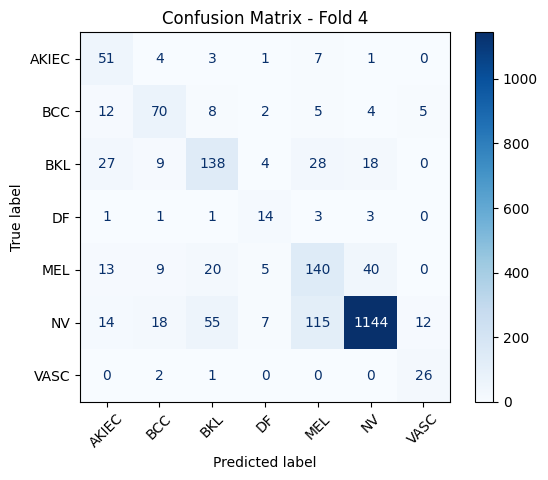


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Epoch 1: Val Loss = 0.9413
Validation loss initialized to 0.9413. Saving model...
Epoch 2: Val Loss = 1.0390
Validation loss did not improve. Counter: 1/10
Epoch 3: Val Loss = 0.8348
Validation loss decreased (0.9413 -> 0.8348). Saving model...
Epoch 4: Val Loss = 0.7977
Validation loss decreased (0.8348 -> 0.7977). Saving model...
Epoch 5: Val Loss = 0.7383
Validation loss decreased (0.7977 -> 0.7383). Saving model...
Epoch 6: Val Loss = 0.8263
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.7205
Validation loss decreased (0.7383 -> 0.7205). Saving model...
Epoch 8: Val Loss = 0.7365
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.7540
Validation loss did not improve. Counter: 2

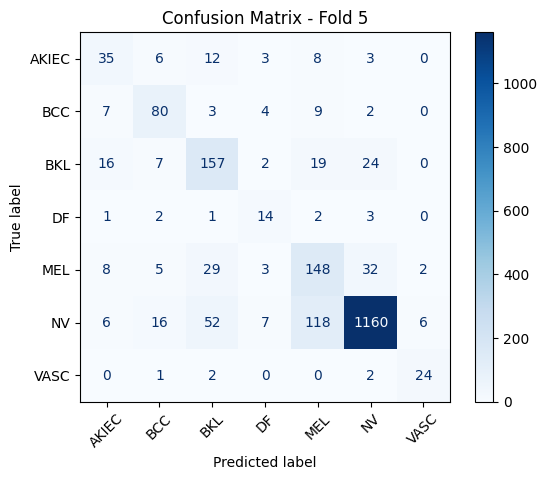


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.5035    0.6448    0.5654       335
         BCC     0.6495    0.7637    0.7020       529
         BKL     0.6447    0.6280    0.6362      1121
          DF     0.4867    0.6293    0.5489       116
         MEL     0.4772    0.6455    0.5487      1134
          NV     0.9398    0.8508    0.8931      6828
        VASC     0.6300    0.8690    0.7304       145

    accuracy                         0.7900     10208
   macro avg     0.6188    0.7187    0.6607     10208
weighted avg     0.8171    0.7900    0.7997     10208

Final Balanced Accuracy: 0.7187


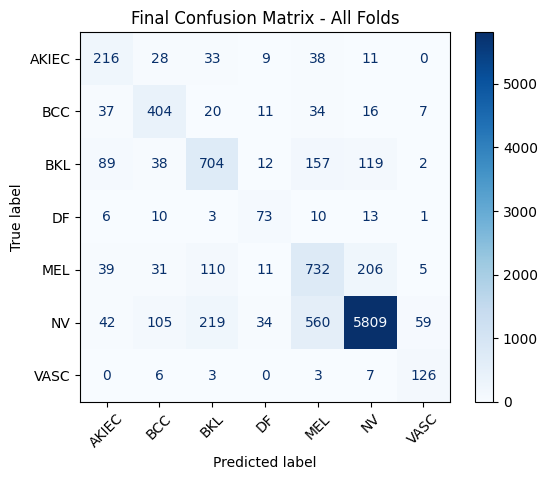

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import Counter

# Parámetros
data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 0.001
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),  # EfficientNet-B3 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset base
base_dataset = datasets.ImageFolder(root=data_path)
targets = np.array(base_dataset.targets)
class_names = base_dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_train), train_idx)
    val_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_val), val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Pesos de clase
    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
    weights = torch.FloatTensor(weights).to(device)

    print("Class Weights (Fold {}):".format(fold + 1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")

    # Modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')
    for name, param in model.named_parameters():
        param.requires_grad = False  # Congelar por defecto

    # Descongelar la cabeza y el último bloque
    for name, param in model.features[-1].named_parameters():
        param.requires_grad = True
    for name, param in model.classifier.named_parameters():
        param.requires_grad = True

    # Reemplazar capa final
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # Optimización
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch + 1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # Evaluación
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold + 1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))
    print(f"Balanced Accuracy: {balanced_accuracy_score(fold_labels, fold_preds):.4f}")

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Resultados Finales
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()



Evaluando modelo fold 0 en el test set...

Evaluando modelo fold 1 en el test set...

Evaluando modelo fold 2 en el test set...

Evaluando modelo fold 3 en el test set...

Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========
              precision    recall  f1-score   support

       AKIEC     0.4576    0.6279    0.5294        43
         BCC     0.6739    0.6667    0.6703        93
         BKL     0.6667    0.6544    0.6605       217
          DF     0.6444    0.6591    0.6517        44
         MEL     0.5266    0.6374    0.5767       171
          NV     0.9218    0.8691    0.8947       909
        VASC     0.6154    0.6857    0.6486        35

    accuracy                         0.7824      1512
   macro avg     0.6438    0.6858    0.6617      1512
weighted avg     0.7969    0.7824    0.7881      1512

Balanced Accuracy: 0.6858


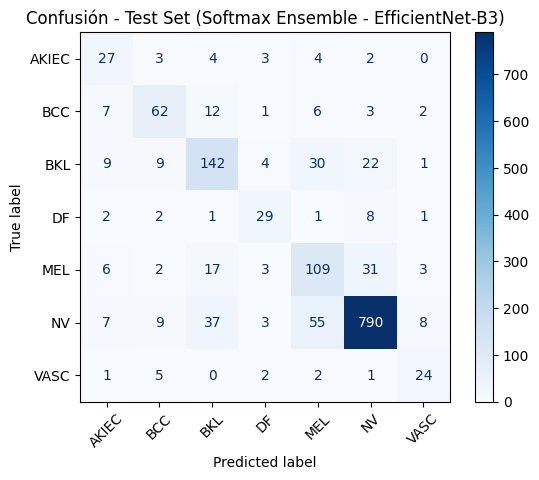

In [10]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import pandas as pd

# ===== Configuración =====
test_path = r"D:\TFM\ISIC2018\test"  # Asegúrate que contiene subcarpetas por clase
batch_size = 32
num_classes = 7
k_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Transformación (EfficientNet-B3, 300x300) =====
transform_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===== Cargar Dataset de Test =====
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_labels = [label for _, label in test_dataset]
class_names = test_dataset.classes

# ===== Ensemble por promedio de softmax =====
all_fold_probs = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set...")

    # Cargar modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    # Cargar pesos entrenados
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model = model.to(device)
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            fold_probs.append(probs.cpu().numpy())

    all_fold_probs.append(np.concatenate(fold_probs, axis=0))

# ===== Promediar predicciones de los folds =====
avg_probs = np.mean(np.array(all_fold_probs), axis=0)
ensemble_preds = np.argmax(avg_probs, axis=1)

# ===== Evaluación Final =====
print("\n======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds):.4f}")

# ===== Matriz de Confusión =====
cm = confusion_matrix(test_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusión - Test Set (Softmax Ensemble - EfficientNet-B3)")
plt.show()


======== Fold 1 ========
Class Weights: tensor([ 4.3529,  2.7579,  1.3005, 12.6801,  1.2848,  0.2136, 10.0567],
       device='cuda:0')
Epoch 1: Val Loss = 1.1015
Validation loss initialized to 1.1015. Saving model...
Epoch 2: Val Loss = 0.8333
Validation loss decreased (1.1015 -> 0.8333). Saving model...
Epoch 3: Val Loss = 0.7335
Validation loss decreased (0.8333 -> 0.7335). Saving model...
Epoch 4: Val Loss = 0.7559
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.7069
Validation loss decreased (0.7335 -> 0.7069). Saving model...
Epoch 6: Val Loss = 0.6666
Validation loss decreased (0.7069 -> 0.6666). Saving model...
Epoch 7: Val Loss = 0.7105
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.5429
Validation loss decreased (0.6666 -> 0.5429). Saving model...
Epoch 9: Val Loss = 0.5091
Validation loss decreased (0.5429 -> 0.5091). Saving model...
Epoch 10: Val Loss = 0.6738
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 0.5

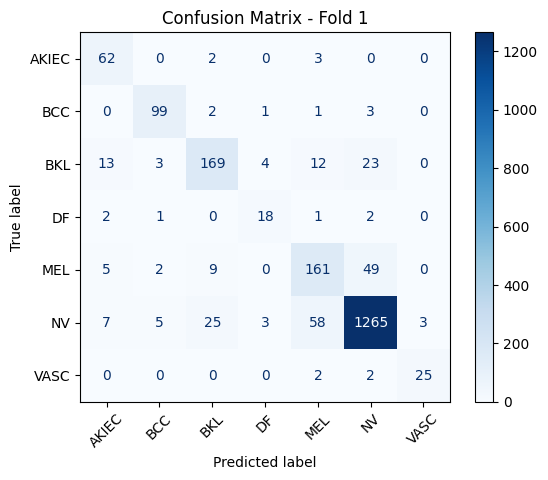


======== Fold 2 ========
Class Weights: tensor([ 4.3529,  2.7579,  1.3005, 12.5438,  1.2862,  0.2136, 10.0567],
       device='cuda:0')
Epoch 1: Val Loss = 1.0113
Validation loss initialized to 1.0113. Saving model...
Epoch 2: Val Loss = 0.9116
Validation loss decreased (1.0113 -> 0.9116). Saving model...
Epoch 3: Val Loss = 0.6644
Validation loss decreased (0.9116 -> 0.6644). Saving model...
Epoch 4: Val Loss = 0.8225
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.5730
Validation loss decreased (0.6644 -> 0.5730). Saving model...
Epoch 6: Val Loss = 1.2827
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.5217
Validation loss decreased (0.5730 -> 0.5217). Saving model...
Epoch 8: Val Loss = 0.7418
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.5671
Validation loss did not improve. Counter: 2/10
Epoch 10: Val Loss = 0.6449
Validation loss did not improve. Counter: 3/10
Epoch 11: Val Loss = 0.5088
Validation loss decreased 

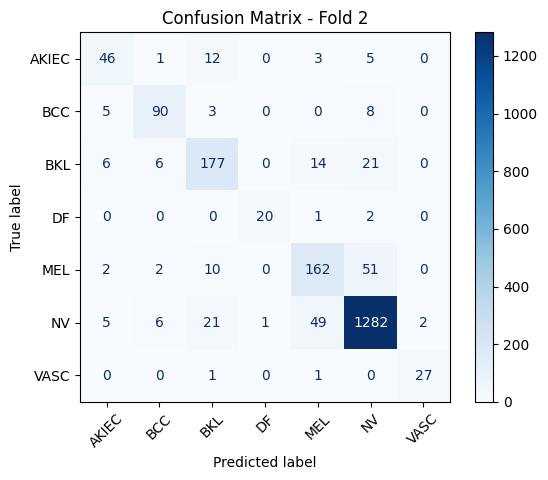


======== Fold 3 ========
Class Weights: tensor([ 4.3529,  2.7579,  1.3005, 12.5438,  1.2862,  0.2136, 10.0567],
       device='cuda:0')
Epoch 1: Val Loss = 0.7046
Validation loss initialized to 0.7046. Saving model...
Epoch 2: Val Loss = 0.6876
Validation loss decreased (0.7046 -> 0.6876). Saving model...
Epoch 3: Val Loss = 0.6137
Validation loss decreased (0.6876 -> 0.6137). Saving model...
Epoch 4: Val Loss = 0.5843
Validation loss decreased (0.6137 -> 0.5843). Saving model...
Epoch 5: Val Loss = 0.6674
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.6020
Validation loss did not improve. Counter: 2/10
Epoch 7: Val Loss = 0.5710
Validation loss decreased (0.5843 -> 0.5710). Saving model...
Epoch 8: Val Loss = 0.5287
Validation loss decreased (0.5710 -> 0.5287). Saving model...
Epoch 9: Val Loss = 0.7831
Validation loss did not improve. Counter: 1/10
Epoch 10: Val Loss = 0.5979
Validation loss did not improve. Counter: 2/10
Epoch 11: Val Loss = 0.5836
Validation 

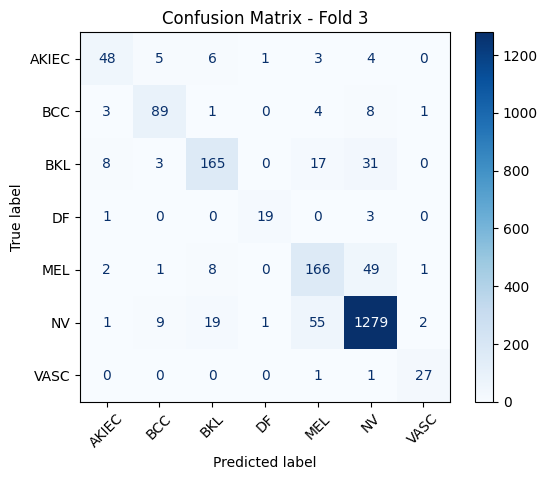


======== Fold 4 ========
Class Weights: tensor([ 4.3534,  2.7582,  1.3007, 12.5453,  1.2863,  0.2136, 10.0579],
       device='cuda:0')
Epoch 1: Val Loss = 0.7959
Validation loss initialized to 0.7959. Saving model...
Epoch 2: Val Loss = 0.6629
Validation loss decreased (0.7959 -> 0.6629). Saving model...
Epoch 3: Val Loss = 0.7427
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 0.6860
Validation loss did not improve. Counter: 2/10
Epoch 5: Val Loss = 0.6196
Validation loss decreased (0.6629 -> 0.6196). Saving model...
Epoch 6: Val Loss = 0.5768
Validation loss decreased (0.6196 -> 0.5768). Saving model...
Epoch 7: Val Loss = 0.7801
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.6324
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.5370
Validation loss decreased (0.5768 -> 0.5370). Saving model...
Epoch 10: Val Loss = 0.5605
Validation loss did not improve. Counter: 1/10
Epoch 11: Val Loss = 0.5362
Validation loss decreased 

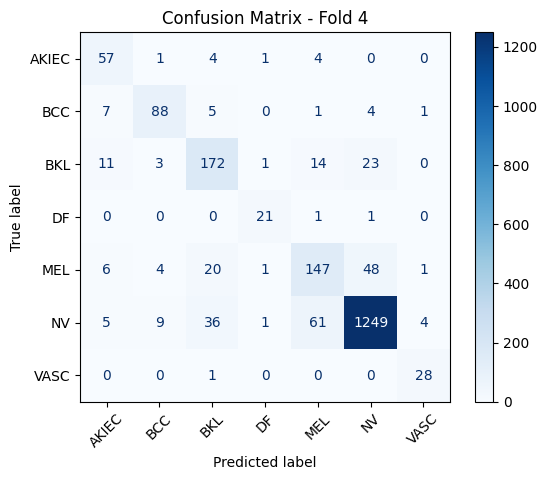


======== Fold 5 ========
Class Weights: tensor([ 4.3534,  2.7517,  1.3021, 12.5453,  1.2863,  0.2136, 10.0579],
       device='cuda:0')
Epoch 1: Val Loss = 0.8395
Validation loss initialized to 0.8395. Saving model...
Epoch 2: Val Loss = 0.7594
Validation loss decreased (0.8395 -> 0.7594). Saving model...
Epoch 3: Val Loss = 0.6056
Validation loss decreased (0.7594 -> 0.6056). Saving model...
Epoch 4: Val Loss = 0.7412
Validation loss did not improve. Counter: 1/10
Epoch 5: Val Loss = 0.4780
Validation loss decreased (0.6056 -> 0.4780). Saving model...
Epoch 6: Val Loss = 0.5835
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.6398
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 0.5148
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 0.7282
Validation loss did not improve. Counter: 4/10
Epoch 10: Val Loss = 0.4400
Validation loss decreased (0.4780 -> 0.4400). Saving model...
Epoch 11: Val Loss = 0.4062
Validation loss decreased 

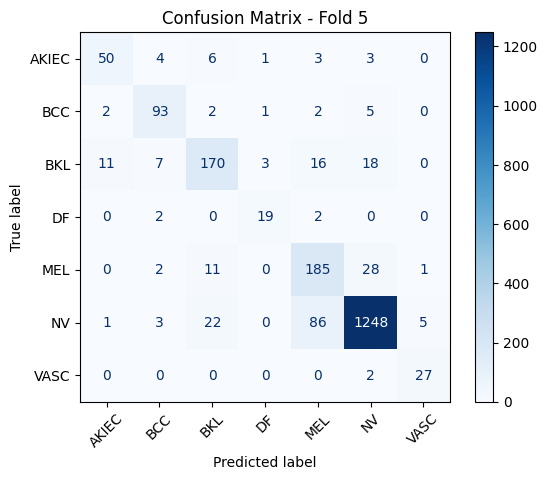


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.7186    0.7851    0.7504       335
         BCC     0.8532    0.8677    0.8604       529
         BKL     0.7905    0.7609    0.7755      1121
          DF     0.8291    0.8362    0.8326       116
         MEL     0.6642    0.7240    0.6928      1134
          NV     0.9413    0.9260    0.9336      6828
        VASC     0.8645    0.9241    0.8933       145

    accuracy                         0.8768     10208
   macro avg     0.8088    0.8320    0.8198     10208
weighted avg     0.8798    0.8768    0.8780     10208

Final Balanced Accuracy: 0.8320


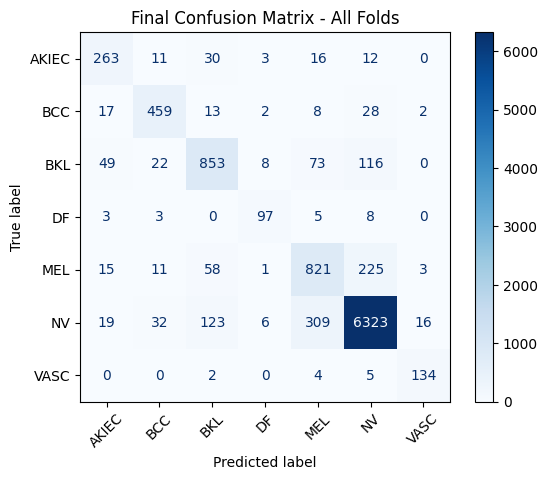

In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import Counter

# Configuración
DATA_PATH = r"D:\TFM\data\train_val_full"
TEST_PATH = r"D:\TFM\ISIC2018\test"
NUM_CLASSES = 7
K_FOLDS = 5
BATCH_SIZE = 32
NUM_EPOCHS = 50
PATIENCE = 10
LR = 1e-3
WEIGHT_DECAY = 1e-4

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Dataset base
base_dataset = datasets.ImageFolder(root=DATA_PATH)
targets = np.array(base_dataset.targets)
class_names = base_dataset.classes

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
all_preds, all_labels = [], []

# Entrenamiento y validación
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform_train)
    val_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform_val)

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Pesos de clase
    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)]
    weights = torch.FloatTensor(weights).to(DEVICE)

    print("Class Weights:", weights)

    # Modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')

    # Descongelar parte final
    for name, param in model.named_parameters():
        param.requires_grad = False
    for name, param in model.features[6:].named_parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    model = model.to(DEVICE)

    # Optimización
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=f'best_model_fold{fold}.pth')

    # Entrenamiento
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validación
        model.eval()
        val_loss, val_preds, val_true = 0.0, [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # Evaluación del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold + 1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))
    print(f"Balanced Accuracy: {balanced_accuracy_score(fold_labels, fold_preds):.4f}")

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Resultados Finales
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()



Evaluando modelo fold 0 en el test set...

Evaluando modelo fold 1 en el test set...

Evaluando modelo fold 2 en el test set...

Evaluando modelo fold 3 en el test set...

Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========
              precision    recall  f1-score   support

       AKIEC     0.5957    0.6512    0.6222        43
         BCC     0.7978    0.7634    0.7802        93
         BKL     0.7929    0.7235    0.7566       217
          DF     0.9118    0.7045    0.7949        44
         MEL     0.6278    0.6608    0.6439       171
          NV     0.9152    0.9384    0.9267       909
        VASC     0.8750    0.8000    0.8358        35

    accuracy                         0.8472      1512
   macro avg     0.7880    0.7488    0.7658      1512
weighted avg     0.8478    0.8472    0.8467      1512

Balanced Accuracy: 0.7488


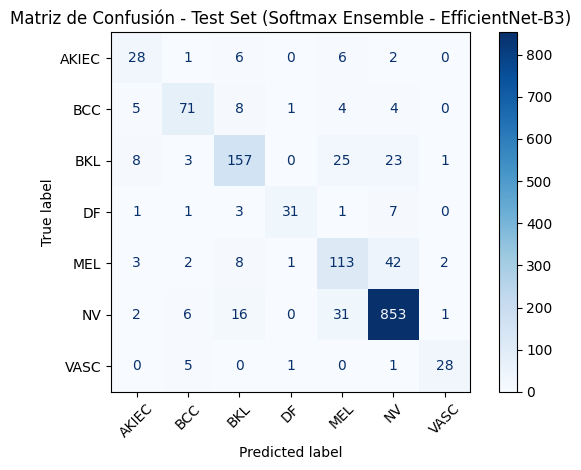

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

# Configuración
test_path = r"D:\TFM\ISIC2018\test"
batch_size = 32
num_classes = 7
k_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformación para test
transform_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Cargar dataset de test
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_labels = [label for _, label in test_dataset]
class_names = test_dataset.classes

# Ensemble por promedio de softmax
all_fold_probs = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set...")

    # Cargar modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    # Cargar pesos del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth', map_location=device))
    model = model.to(device)
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            fold_probs.append(probs.cpu().numpy())

    all_fold_probs.append(np.concatenate(fold_probs, axis=0))

# Promedio de predicciones
avg_probs = np.mean(np.array(all_fold_probs), axis=0)
ensemble_preds = np.argmax(avg_probs, axis=1)

# Evaluación
print("\n======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds):.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Softmax Ensemble - EfficientNet-B3)")
plt.tight_layout()
plt.show()


======== Fold 1 ========
Epoch 1: Val Loss = 0.5104
Validation loss initialized to 0.5104. Saving model...
Epoch 2: Val Loss = 0.4252
Validation loss decreased (0.5104 -> 0.4252). Saving model...
Epoch 3: Val Loss = 0.3954
Validation loss decreased (0.4252 -> 0.3954). Saving model...
Epoch 4: Val Loss = 0.3758
Validation loss decreased (0.3954 -> 0.3758). Saving model...
Epoch 5: Val Loss = 0.3623
Validation loss decreased (0.3758 -> 0.3623). Saving model...
Epoch 6: Val Loss = 0.4139
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.4020
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 0.3879
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 0.4001
Validation loss did not improve. Counter: 4/10
Epoch 10: Val Loss = 0.3590
Validation loss decreased (0.3623 -> 0.3590). Saving model...
Epoch 11: Val Loss = 0.3620
Validation loss did not improve. Counter: 1/10
Epoch 12: Val Loss = 0.3812
Validation loss did not improve. Counter: 2/10


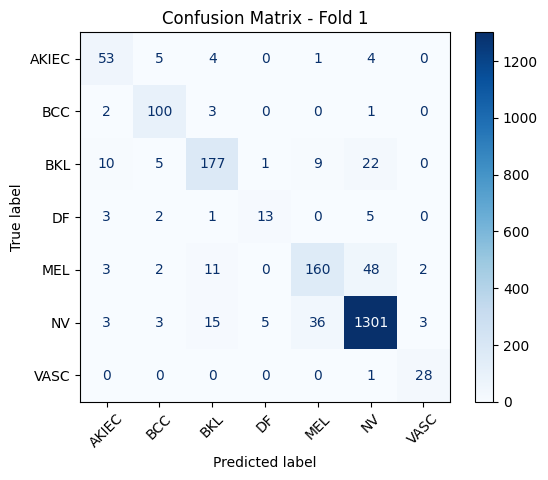


======== Fold 2 ========
Epoch 1: Val Loss = 0.5225
Validation loss initialized to 0.5225. Saving model...
Epoch 2: Val Loss = 0.4259
Validation loss decreased (0.5225 -> 0.4259). Saving model...
Epoch 3: Val Loss = 0.3944
Validation loss decreased (0.4259 -> 0.3944). Saving model...
Epoch 4: Val Loss = 0.3749
Validation loss decreased (0.3944 -> 0.3749). Saving model...
Epoch 5: Val Loss = 0.3681
Validation loss decreased (0.3749 -> 0.3681). Saving model...
Epoch 6: Val Loss = 0.3976
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.3951
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 0.4178
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 0.4621
Validation loss did not improve. Counter: 4/10
Epoch 10: Val Loss = 0.3808
Validation loss did not improve. Counter: 5/10
Epoch 11: Val Loss = 0.3971
Validation loss did not improve. Counter: 6/10
Epoch 12: Val Loss = 0.3933
Validation loss did not improve. Counter: 7/10
Epoch 13: Val L

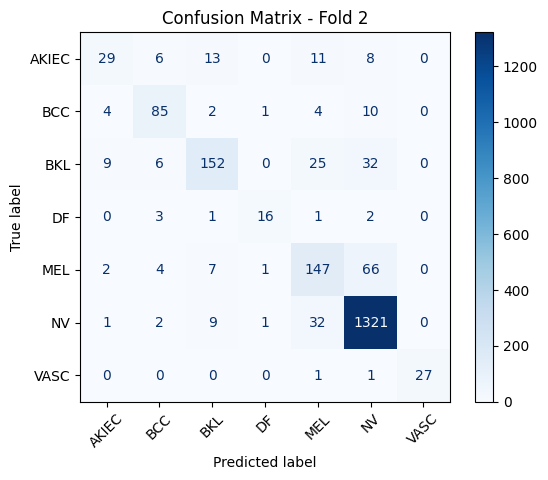


======== Fold 3 ========
Epoch 1: Val Loss = 0.5323
Validation loss initialized to 0.5323. Saving model...
Epoch 2: Val Loss = 0.4669
Validation loss decreased (0.5323 -> 0.4669). Saving model...
Epoch 3: Val Loss = 0.4227
Validation loss decreased (0.4669 -> 0.4227). Saving model...
Epoch 4: Val Loss = 0.4058
Validation loss decreased (0.4227 -> 0.4058). Saving model...
Epoch 5: Val Loss = 0.3917
Validation loss decreased (0.4058 -> 0.3917). Saving model...
Epoch 6: Val Loss = 0.3864
Validation loss decreased (0.3917 -> 0.3864). Saving model...
Epoch 7: Val Loss = 0.3938
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.4354
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.4187
Validation loss did not improve. Counter: 3/10
Epoch 10: Val Loss = 0.4179
Validation loss did not improve. Counter: 4/10
Epoch 11: Val Loss = 0.3997
Validation loss did not improve. Counter: 5/10
Epoch 12: Val Loss = 0.3975
Validation loss did not improve. Counter: 6/10


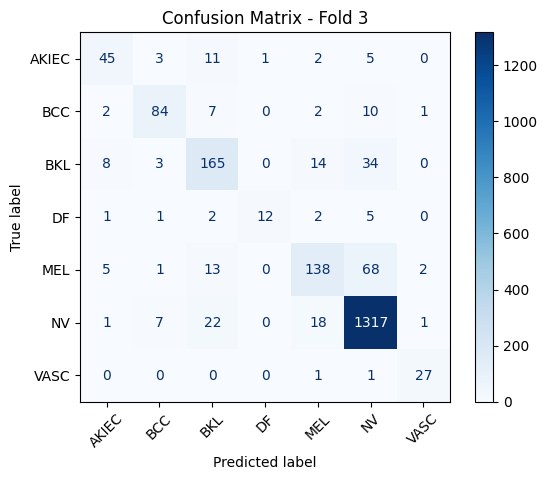


======== Fold 4 ========
Epoch 1: Val Loss = 0.5333
Validation loss initialized to 0.5333. Saving model...
Epoch 2: Val Loss = 0.4563
Validation loss decreased (0.5333 -> 0.4563). Saving model...
Epoch 3: Val Loss = 0.4637
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 0.4204
Validation loss decreased (0.4563 -> 0.4204). Saving model...
Epoch 5: Val Loss = 0.3827
Validation loss decreased (0.4204 -> 0.3827). Saving model...
Epoch 6: Val Loss = 0.4384
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.4072
Validation loss did not improve. Counter: 2/10
Epoch 8: Val Loss = 0.4439
Validation loss did not improve. Counter: 3/10
Epoch 9: Val Loss = 0.4478
Validation loss did not improve. Counter: 4/10
Epoch 10: Val Loss = 0.4036
Validation loss did not improve. Counter: 5/10
Epoch 11: Val Loss = 0.4164
Validation loss did not improve. Counter: 6/10
Epoch 12: Val Loss = 0.4108
Validation loss did not improve. Counter: 7/10
Epoch 13: Val Loss = 0.4151
Va

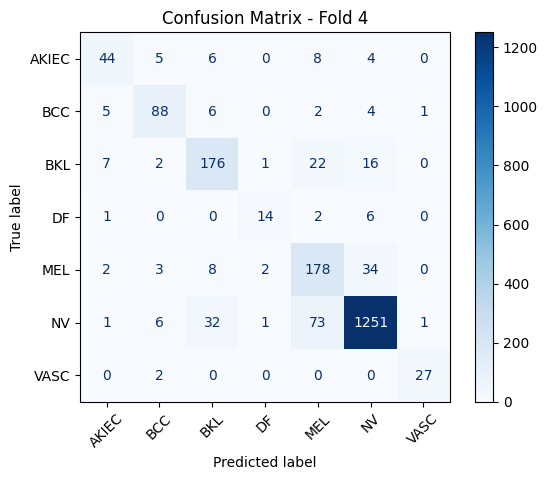


======== Fold 5 ========
Epoch 1: Val Loss = 0.5251
Validation loss initialized to 0.5251. Saving model...
Epoch 2: Val Loss = 0.4138
Validation loss decreased (0.5251 -> 0.4138). Saving model...
Epoch 3: Val Loss = 0.3899
Validation loss decreased (0.4138 -> 0.3899). Saving model...
Epoch 4: Val Loss = 0.3776
Validation loss decreased (0.3899 -> 0.3776). Saving model...
Epoch 5: Val Loss = 0.3796
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.3879
Validation loss did not improve. Counter: 2/10
Epoch 7: Val Loss = 0.4121
Validation loss did not improve. Counter: 3/10
Epoch 8: Val Loss = 0.3686
Validation loss decreased (0.3776 -> 0.3686). Saving model...
Epoch 9: Val Loss = 0.4022
Validation loss did not improve. Counter: 1/10
Epoch 10: Val Loss = 0.4648
Validation loss did not improve. Counter: 2/10
Epoch 11: Val Loss = 0.4730
Validation loss did not improve. Counter: 3/10
Epoch 12: Val Loss = 0.4471
Validation loss did not improve. Counter: 4/10
Epoch 13: Val L

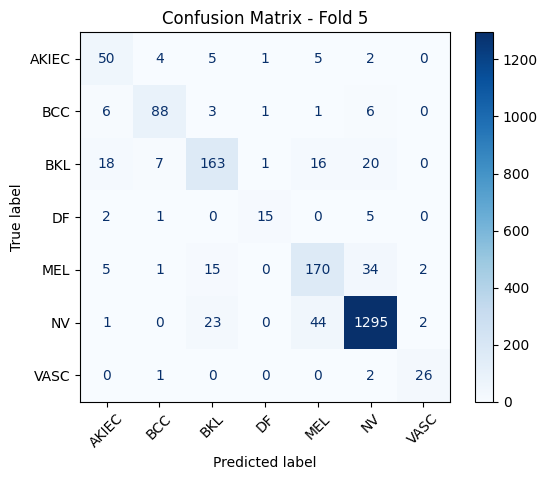


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.6842    0.6597    0.6717       335
         BCC     0.8396    0.8412    0.8404       529
         BKL     0.7918    0.7431    0.7667      1121
          DF     0.8046    0.6034    0.6897       116
         MEL     0.7049    0.6993    0.7021      1134
          NV     0.9343    0.9498    0.9420      6828
        VASC     0.9000    0.9310    0.9153       145

    accuracy                         0.8799     10208
   macro avg     0.8085    0.7754    0.7897     10208
weighted avg     0.8781    0.8799    0.8787     10208

Final Balanced Accuracy: 0.7754


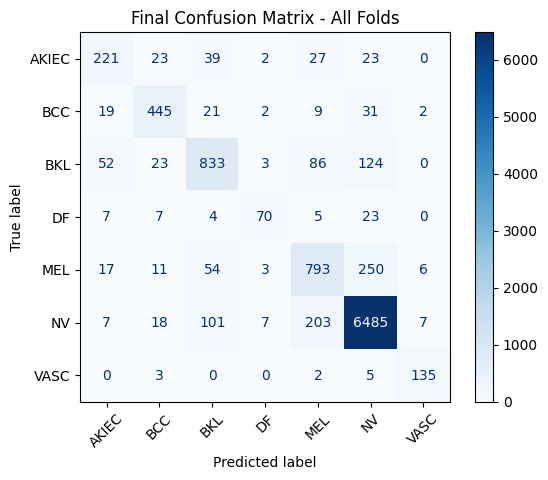

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import Counter

# Configuración
data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 1e-3
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones
def get_transforms():
    transform_train = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    transform_val = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform_train, transform_val

transform_train, transform_val = get_transforms()

# Dataset base
base_dataset = datasets.ImageFolder(root=data_path)
targets = np.array(base_dataset.targets)
class_names = base_dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

# Entrenamiento y validación
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_train), train_idx)
    val_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_val), val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')

    # Congelar todo
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar últimos bloques
    for param in model.features[5:].parameters():
        param.requires_grad = True

    # Descongelar clasificación
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.to(device)

    # Optimizador con LR diferenciado
    optimizer = optim.Adam([
        {'params': model.features[5:].parameters(), 'lr': learning_rate * 0.1},
        {'params': model.classifier.parameters(), 'lr': learning_rate}
    ], weight_decay=weight_decay)

    # Criterio y scheduler
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

    # Early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch + 1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # Evaluación del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold + 1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))
    print(f"Balanced Accuracy: {balanced_accuracy_score(fold_labels, fold_preds):.4f}")

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Resultados Finales
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()



Evaluando modelo fold 0 en el test set...

Evaluando modelo fold 1 en el test set...

Evaluando modelo fold 2 en el test set...

Evaluando modelo fold 3 en el test set...

Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========
              precision    recall  f1-score   support

       AKIEC     0.6222    0.6512    0.6364        43
         BCC     0.7802    0.7634    0.7717        93
         BKL     0.8201    0.7143    0.7635       217
          DF     0.9231    0.5455    0.6857        44
         MEL     0.6959    0.6023    0.6458       171
          NV     0.8882    0.9615    0.9234       909
        VASC     0.8276    0.6857    0.7500        35

    accuracy                         0.8459      1512
   macro avg     0.7939    0.7034    0.7395      1512
weighted avg     0.8421    0.8459    0.8406      1512

Balanced Accuracy: 0.7034


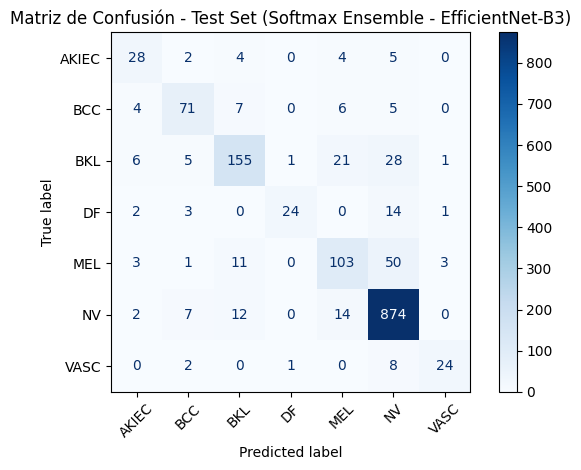

In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

# Configuración
test_path = r"D:\TFM\ISIC2018\test"
batch_size = 32
num_classes = 7
k_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformación para test
transform_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Cargar dataset de test
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_labels = [label for _, label in test_dataset]
class_names = test_dataset.classes

# Ensemble por promedio de softmax
all_fold_probs = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set...")

    # Cargar modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    # Cargar pesos del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth', map_location=device))
    model = model.to(device)
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            fold_probs.append(probs.cpu().numpy())

    all_fold_probs.append(np.concatenate(fold_probs, axis=0))

# Promedio de predicciones
avg_probs = np.mean(np.array(all_fold_probs), axis=0)
ensemble_preds = np.argmax(avg_probs, axis=1)

# Evaluación
print("\n======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds):.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Softmax Ensemble - EfficientNet-B3)")
plt.tight_layout()
plt.show()


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 0.8007
Validation loss initialized to 0.8007. Saving model...
Epoch 2: Val Loss = 0.6289
Validation loss decreased (0.8007 -> 0.6289). Saving model...
Epoch 3: Val Loss = 0.5802
Validation loss decreased (0.6289 -> 0.5802). Saving model...
Epoch 4: Val Loss = 0.5038
Validation loss decreased (0.5802 -> 0.5038). Saving model...
Epoch 5: Val Loss = 0.4837
Validation loss decreased (0.5038 -> 0.4837). Saving model...
Epoch 6: Val Loss = 0.5066
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.4458
Validation loss decreased (0.4837 -> 0.4458). Saving model...
Epoch 8: Val Loss = 0.4374
Validation loss decreased (0.4458 -> 0.4374). Saving model...
Epoch 9: Val Loss = 0.4052
Validation lo

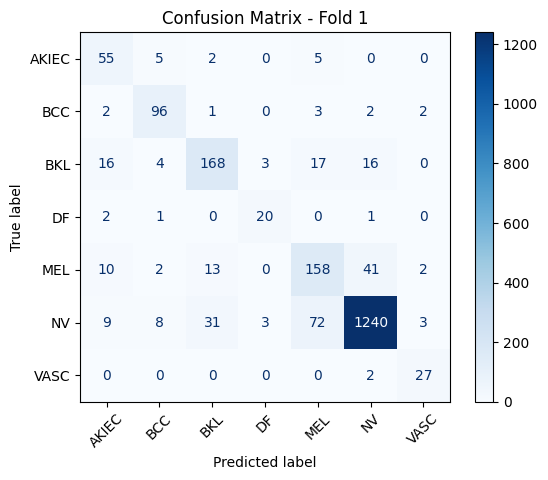


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 0.7878
Validation loss initialized to 0.7878. Saving model...
Epoch 2: Val Loss = 0.5469
Validation loss decreased (0.7878 -> 0.5469). Saving model...
Epoch 3: Val Loss = 0.5745
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 0.5136
Validation loss decreased (0.5469 -> 0.5136). Saving model...
Epoch 5: Val Loss = 0.4536
Validation loss decreased (0.5136 -> 0.4536). Saving model...
Epoch 6: Val Loss = 0.5192
Validation loss did not improve. Counter: 1/10
Epoch 7: Val Loss = 0.4520
Validation loss decreased (0.4536 -> 0.4520). Saving model...
Epoch 8: Val Loss = 0.4645
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.4142
Validation loss decreased (0.4520 -> 0.4142

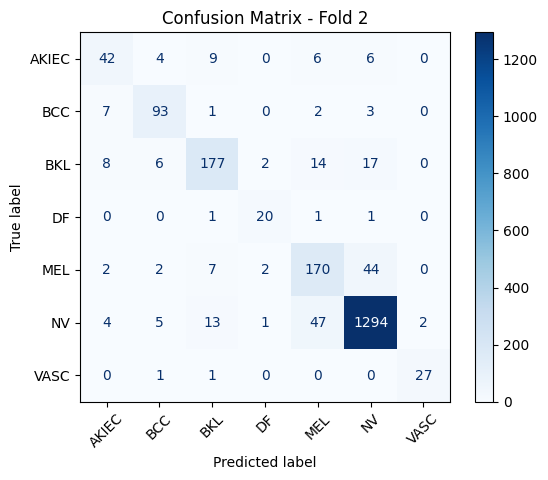


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Epoch 1: Val Loss = 0.7387
Validation loss initialized to 0.7387. Saving model...
Epoch 2: Val Loss = 0.5707
Validation loss decreased (0.7387 -> 0.5707). Saving model...
Epoch 3: Val Loss = 0.6129
Validation loss did not improve. Counter: 1/10
Epoch 4: Val Loss = 0.5780
Validation loss did not improve. Counter: 2/10
Epoch 5: Val Loss = 0.4823
Validation loss decreased (0.5707 -> 0.4823). Saving model...
Epoch 6: Val Loss = 0.4262
Validation loss decreased (0.4823 -> 0.4262). Saving model...
Epoch 7: Val Loss = 0.5380
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.4641
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.4352
Validation loss did not improve. Counter: 3/10
Epoch 10: V

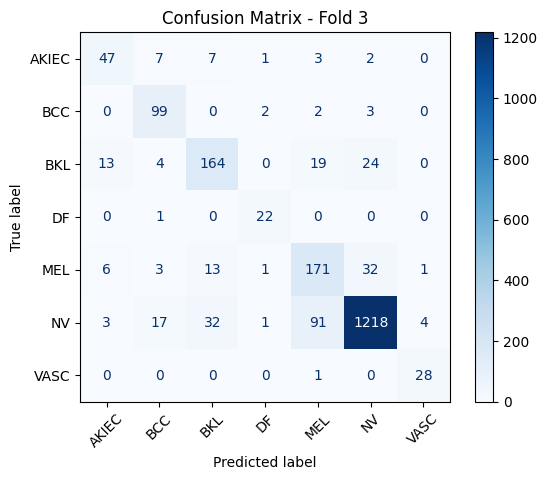


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Epoch 1: Val Loss = 0.8504
Validation loss initialized to 0.8504. Saving model...
Epoch 2: Val Loss = 0.7254
Validation loss decreased (0.8504 -> 0.7254). Saving model...
Epoch 3: Val Loss = 0.5824
Validation loss decreased (0.7254 -> 0.5824). Saving model...
Epoch 4: Val Loss = 0.5656
Validation loss decreased (0.5824 -> 0.5656). Saving model...
Epoch 5: Val Loss = 0.5923
Validation loss did not improve. Counter: 1/10
Epoch 6: Val Loss = 0.4972
Validation loss decreased (0.5656 -> 0.4972). Saving model...
Epoch 7: Val Loss = 0.4936
Validation loss decreased (0.4972 -> 0.4936). Saving model...
Epoch 8: Val Loss = 0.5125
Validation loss did not improve. Counter: 1/10
Epoch 9: Val Loss = 0.5295
Validation loss did not impr

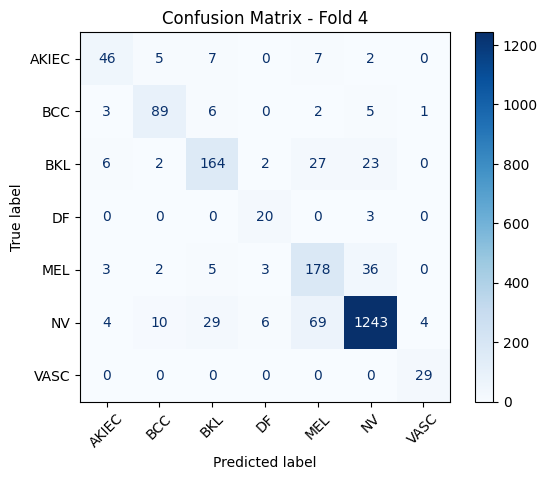


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Epoch 1: Val Loss = 0.7389
Validation loss initialized to 0.7389. Saving model...
Epoch 2: Val Loss = 0.6045
Validation loss decreased (0.7389 -> 0.6045). Saving model...
Epoch 3: Val Loss = 0.5784
Validation loss decreased (0.6045 -> 0.5784). Saving model...
Epoch 4: Val Loss = 0.5473
Validation loss decreased (0.5784 -> 0.5473). Saving model...
Epoch 5: Val Loss = 0.5284
Validation loss decreased (0.5473 -> 0.5284). Saving model...
Epoch 6: Val Loss = 0.4517
Validation loss decreased (0.5284 -> 0.4517). Saving model...
Epoch 7: Val Loss = 0.4570
Validation loss did not improve. Counter: 1/10
Epoch 8: Val Loss = 0.5041
Validation loss did not improve. Counter: 2/10
Epoch 9: Val Loss = 0.4406
Validation loss decreased (0

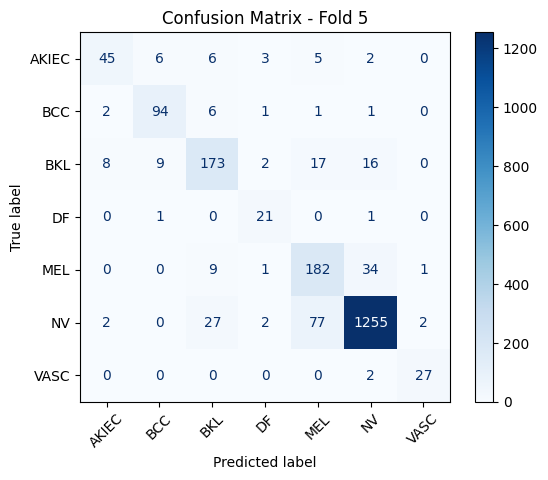


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.6812    0.7015    0.6912       335
         BCC     0.8177    0.8904    0.8525       529
         BKL     0.7892    0.7547    0.7715      1121
          DF     0.7410    0.8879    0.8078       116
         MEL     0.6377    0.7575    0.6925      1134
          NV     0.9514    0.9153    0.9330      6828
        VASC     0.8625    0.9517    0.9049       145

    accuracy                         0.8721     10208
   macro avg     0.7830    0.8370    0.8076     10208
weighted avg     0.8793    0.8721    0.8746     10208

Final Balanced Accuracy: 0.8370


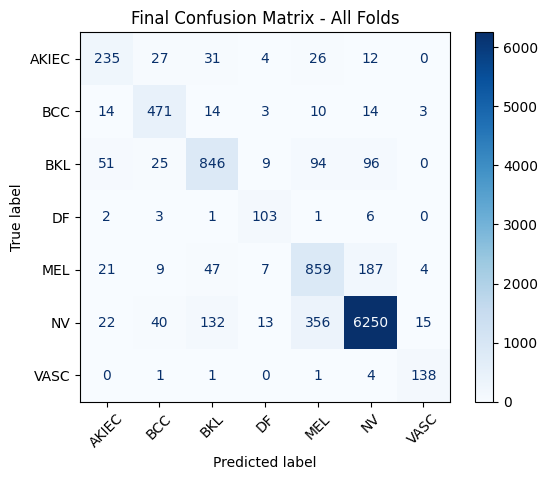

In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import Counter

# Configuración
data_path = r"D:\TFM\data\train_val_full"
k_folds = 5
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 1e-3
weight_decay = 1e-4
num_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones
def get_transforms():
    transform_train = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    transform_val = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform_train, transform_val

transform_train, transform_val = get_transforms()

# Dataset base
base_dataset = datasets.ImageFolder(root=data_path)
targets = np.array(base_dataset.targets)
class_names = base_dataset.classes

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

# Entrenamiento y validación
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_train), train_idx)
    val_subset = Subset(datasets.ImageFolder(root=data_path, transform=transform_val), val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Pesos de clase
    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    weights = [total / (num_classes * class_counts[i]) for i in range(num_classes)]
    weights = torch.FloatTensor(weights).to(device)

    print("Class Weights (Fold {}):".format(fold + 1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")

    # Modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')

    # Congelar todo
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar últimos bloques
    for param in model.features[5:].parameters():
        param.requires_grad = True

    # Descongelar clasificación
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.to(device)

    # Optimizador con LR diferenciado
    optimizer = optim.Adam([
        {'params': model.features[5:].parameters(), 'lr': learning_rate * 0.1},
        {'params': model.classifier.parameters(), 'lr': learning_rate}
    ], weight_decay=weight_decay)

    # Criterio y scheduler
    criterion = nn.CrossEntropyLoss(weight=weights)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

    # Early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'best_model_fold{fold}.pth')

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch + 1}: Val Loss = {avg_val_loss:.4f}")

        if early_stopping(model, avg_val_loss):
            print("Early stopping triggered.")
            break

    # Evaluación del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"\nClassification Report - Fold {fold + 1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))
    print(f"Balanced Accuracy: {balanced_accuracy_score(fold_labels, fold_preds):.4f}")

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Resultados Finales
print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Balanced Accuracy: {balanced_accuracy_score(all_labels, all_preds):.4f}")

final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()


Evaluando modelo fold 0 en el test set...

Evaluando modelo fold 1 en el test set...

Evaluando modelo fold 2 en el test set...

Evaluando modelo fold 3 en el test set...

Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========
              precision    recall  f1-score   support

       AKIEC     0.6279    0.6279    0.6279        43
         BCC     0.8023    0.7419    0.7709        93
         BKL     0.8030    0.7512    0.7762       217
          DF     0.8421    0.7273    0.7805        44
         MEL     0.6064    0.6667    0.6351       171
          NV     0.9143    0.9274    0.9208       909
        VASC     0.8438    0.7714    0.8060        35

    accuracy                         0.8433      1512
   macro avg     0.7771    0.7448    0.7596      1512
weighted avg     0.8447    0.8433    0.8435      1512

Balanced Accuracy: 0.7448


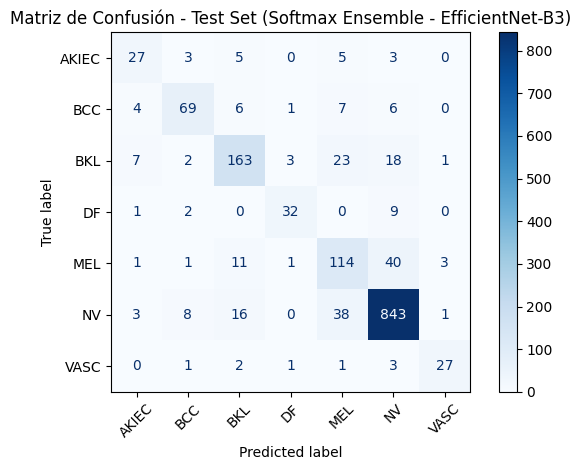

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

# Configuración
test_path = r"D:\TFM\ISIC2018\test"
batch_size = 32
num_classes = 7
k_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformación para test
transform_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Cargar dataset de test
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_labels = [label for _, label in test_dataset]
class_names = test_dataset.classes

# Ensemble por promedio de softmax
all_fold_probs = []

for fold in range(k_folds):
    print(f"\nEvaluando modelo fold {fold} en el test set...")

    # Cargar modelo EfficientNet-B3
    model = models.efficientnet_b3(weights='DEFAULT')
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    # Cargar pesos del fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth', map_location=device))
    model = model.to(device)
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            fold_probs.append(probs.cpu().numpy())

    all_fold_probs.append(np.concatenate(fold_probs, axis=0))

# Promedio de predicciones
avg_probs = np.mean(np.array(all_fold_probs), axis=0)
ensemble_preds = np.argmax(avg_probs, axis=1)

# Evaluación
print("\n======== Resultados del Test Set (EfficientNet-B3 Softmax Ensemble) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))
print(f"Balanced Accuracy: {balanced_accuracy_score(test_labels, ensemble_preds):.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Softmax Ensemble - EfficientNet-B3)")
plt.tight_layout()
plt.show()

**Few Shot**

In [8]:
import torch
from torch import nn
from torchvision import models

class ProtoNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b3(weights='DEFAULT')
        base.classifier = nn.Identity()
        self.encoder = base
        self.output_dim = 1536

        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
        for param in self.encoder.features[5:].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.encoder(x)

In [9]:
import os
import random
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class FewShotISICDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.class_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset.samples):
            self.class_to_indices.setdefault(label, []).append(idx)
        self.transform = transform
        self.classes = list(self.class_to_indices.keys())

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def get_episode(self, n_way=5, k_shot=5, q_queries=15):
        support_x, support_y, query_x, query_y = [], [], [], []
        selected_classes = random.sample(self.classes, n_way)

        for i, cls in enumerate(selected_classes):
            indices = random.sample(self.class_to_indices[cls], k_shot + q_queries)
            s_idx, q_idx = indices[:k_shot], indices[k_shot:]

            support_x.extend([self.dataset[j][0] for j in s_idx])
            support_y.extend([i] * k_shot)
            query_x.extend([self.dataset[j][0] for j in q_idx])
            query_y.extend([i] * q_queries)

        return (
            torch.stack(support_x),
            torch.tensor(support_y),
            torch.stack(query_x),
            torch.tensor(query_y)
        )


In [10]:
def euclidean_dist(a, b):
    n, m = a.size(0), b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    return torch.pow(a - b, 2).sum(2)

def train_protonet(model, dataset, device, n_way=5, k_shot=5, q_queries=15, episodes=100, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(epochs):
        losses, accs = [], []
        for _ in range(episodes):
            sx, sy, qx, qy = dataset.get_episode(n_way, k_shot, q_queries)
            sx, sy = sx.to(device), sy.to(device)
            qx, qy = qx.to(device), qy.to(device)

            proto = model(sx)
            query = model(qx)

            prototypes = torch.stack([proto[sy == i].mean(0) for i in range(n_way)])
            dists = euclidean_dist(query, prototypes)
            log_p_y = (-dists).log_softmax(dim=1)

            loss = nn.NLLLoss()(log_p_y, qy)
            acc = (log_p_y.argmax(dim=1) == qy).float().mean().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            accs.append(acc)

        print(f"[Epoch {epoch+1}] Loss: {np.mean(losses):.4f}, Acc: {np.mean(accs)*100:.2f}%")


In [11]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_on_test(model, dataset, support_shots=5):
    model.eval()
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    labels = [label for _, label in dataset.dataset.samples]
    class_to_idx = dataset.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for inputs, lbls in test_loader:
            inputs = inputs.to(next(model.parameters()).device)
            emb = model(inputs).cpu()
            all_embeddings.append(emb)
            all_labels.extend(lbls)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.tensor(all_labels)

    support_prototypes = []
    for cls in sorted(set(all_labels.tolist())):
        cls_idxs = (all_labels == cls).nonzero().squeeze()[:support_shots]
        proto = all_embeddings[cls_idxs].mean(0)
        support_prototypes.append(proto)
    support_prototypes = torch.stack(support_prototypes)

    dists = euclidean_dist(all_embeddings, support_prototypes)
    preds = dists.argmin(dim=1)

    print("\nClassification Report (Few-Shot Prototype Evaluation):")
    print(classification_report(all_labels, preds, target_names=list(idx_to_class.values()), digits=4))

    cm = confusion_matrix(all_labels, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_class.values())).plot(
        xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix (Prototype-based)")
    plt.tight_layout()
    plt.show()


In [12]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_path = r"D:\TFM\data\train_val_full"
test_path = r"D:\TFM\ISIC2018\test"

fs_dataset = FewShotISICDataset(data_path, transform=transform)
test_dataset = FewShotISICDataset(test_path, transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[Epoch 1] Loss: 8.1141, Acc: 25.94%
[Epoch 2] Loss: 3.1755, Acc: 29.49%
[Epoch 3] Loss: 2.0514, Acc: 31.31%
[Epoch 4] Loss: 1.6998, Acc: 34.97%
[Epoch 5] Loss: 1.5799, Acc: 38.40%
[Epoch 6] Loss: 1.4283, Acc: 42.37%
[Epoch 7] Loss: 1.3302, Acc: 47.37%
[Epoch 8] Loss: 1.2862, Acc: 48.60%
[Epoch 9] Loss: 1.1719, Acc: 52.89%
[Epoch 10] Loss: 1.0647, Acc: 57.63%
[Epoch 11] Loss: 0.9848, Acc: 60.17%
[Epoch 12] Loss: 0.9078, Acc: 62.91%
[Epoch 13] Loss: 0.8333, Acc: 65.63%
[Epoch 14] Loss: 0.8428, Acc: 65.83%
[Epoch 15] Loss: 0.7632, Acc: 69.69%
[Epoch 16] Loss: 0.7041, Acc: 71.37%
[Epoch 17] Loss: 0.6527, Acc: 74.17%
[Epoch 18] Loss: 0.5996, Acc: 74.77%
[Epoch 19] Loss: 0.5804, Acc: 75.63%
[Epoch 20] Loss: 0.5518, Acc: 77.11%
[Epoch 21] Loss: 0.5272, Acc: 78.69%
[Epoch 22] Loss: 0.4341, Acc: 82.40%
[Epoch 23] Loss: 0.4397, Acc: 82.11%
[Epoch 24] Loss: 0.4363, Acc: 81.66%
[Epoch 25] Loss: 0.4044, Acc: 84.40%
[Epoch 26] Loss: 0.3620, Acc: 85.57%
[Epoch 27] Loss: 0.3685, Acc: 84.94%
[Epoch 28]

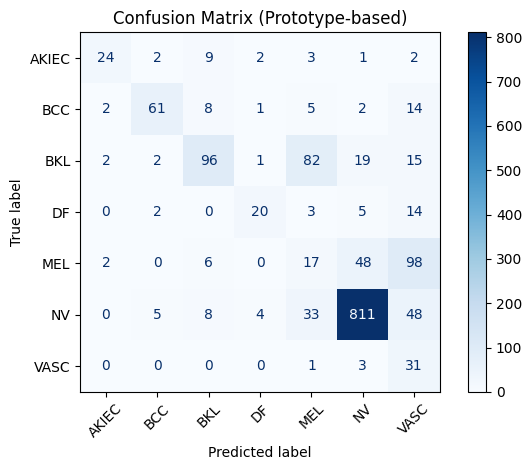

In [16]:
# 1-shot
model = ProtoNet().to(device)
train_protonet(
    model,
    fs_dataset,
    device,
    n_way=7,
    k_shot=1,
    q_queries=5,
    epochs=100
)
evaluate_on_test(model, test_dataset, support_shots=1)

[Epoch 1] Loss: 3.4658, Acc: 38.51%
[Epoch 2] Loss: 1.5119, Acc: 49.49%
[Epoch 3] Loss: 1.0782, Acc: 59.60%
[Epoch 4] Loss: 0.9137, Acc: 66.40%
[Epoch 5] Loss: 0.7573, Acc: 70.74%
[Epoch 6] Loss: 0.6967, Acc: 72.57%
[Epoch 7] Loss: 0.5768, Acc: 78.03%
[Epoch 8] Loss: 0.5282, Acc: 80.63%
[Epoch 9] Loss: 0.5134, Acc: 79.71%
[Epoch 10] Loss: 0.4282, Acc: 84.54%
[Epoch 11] Loss: 0.3583, Acc: 85.91%
[Epoch 12] Loss: 0.3154, Acc: 88.14%
[Epoch 13] Loss: 0.3176, Acc: 87.94%
[Epoch 14] Loss: 0.2587, Acc: 90.31%
[Epoch 15] Loss: 0.2322, Acc: 91.89%
[Epoch 16] Loss: 0.2061, Acc: 92.57%
[Epoch 17] Loss: 0.2029, Acc: 92.83%
[Epoch 18] Loss: 0.1565, Acc: 94.23%
[Epoch 19] Loss: 0.1660, Acc: 94.49%
[Epoch 20] Loss: 0.1430, Acc: 94.66%
[Epoch 21] Loss: 0.1256, Acc: 95.71%
[Epoch 22] Loss: 0.1265, Acc: 95.77%
[Epoch 23] Loss: 0.0996, Acc: 96.86%
[Epoch 24] Loss: 0.0950, Acc: 96.71%
[Epoch 25] Loss: 0.0879, Acc: 96.91%
[Epoch 26] Loss: 0.0862, Acc: 97.40%
[Epoch 27] Loss: 0.1044, Acc: 96.51%
[Epoch 28]

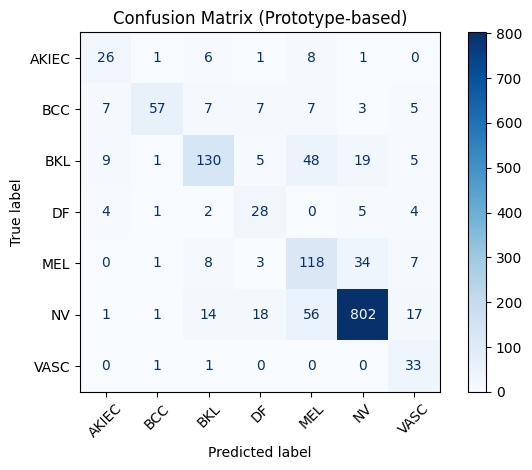

In [15]:
# 3-shot
model = ProtoNet().to(device)
train_protonet(
    model,
    fs_dataset,
    device,
    n_way=7,
    k_shot=3,
    q_queries=5,
    epochs=100
)
evaluate_on_test(model, test_dataset, support_shots=3)


In [ ]:
# 5-shot
model = ProtoNet().to(device)
train_protonet(
    model,
    fs_dataset,
    device,
    n_way=7,
    k_shot=5,
    q_queries=5,
    epochs=60
)
evaluate_on_test(model, test_dataset, support_shots=5)


[Epoch 1] Loss: 2.5274, Acc: 45.74%
[Epoch 2] Loss: 1.1826, Acc: 58.51%
[Epoch 3] Loss: 0.8684, Acc: 67.40%
[Epoch 4] Loss: 0.7365, Acc: 72.49%
[Epoch 5] Loss: 0.6182, Acc: 75.89%
[Epoch 6] Loss: 0.5305, Acc: 80.34%
[Epoch 7] Loss: 0.4358, Acc: 83.49%
[Epoch 8] Loss: 0.3781, Acc: 85.94%
[Epoch 9] Loss: 0.3460, Acc: 87.51%
[Epoch 10] Loss: 0.2935, Acc: 89.20%
[Epoch 11] Loss: 0.2634, Acc: 90.17%
[Epoch 12] Loss: 0.2384, Acc: 90.89%
[Epoch 13] Loss: 0.2168, Acc: 92.20%
[Epoch 14] Loss: 0.1777, Acc: 94.09%
[Epoch 15] Loss: 0.1802, Acc: 93.80%
[Epoch 16] Loss: 0.1675, Acc: 94.26%
[Epoch 17] Loss: 0.1368, Acc: 95.11%
[Epoch 18] Loss: 0.1415, Acc: 95.09%
[Epoch 19] Loss: 0.1323, Acc: 95.26%
[Epoch 20] Loss: 0.1161, Acc: 96.46%
[Epoch 21] Loss: 0.1007, Acc: 96.71%
[Epoch 22] Loss: 0.0903, Acc: 96.77%
[Epoch 23] Loss: 0.0992, Acc: 96.83%
[Epoch 24] Loss: 0.0733, Acc: 97.54%
[Epoch 25] Loss: 0.0716, Acc: 97.00%
[Epoch 26] Loss: 0.0705, Acc: 97.80%
[Epoch 27] Loss: 0.0610, Acc: 97.89%
[Epoch 28]

KeyboardInterrupt: 


Classification Report (Few-Shot Prototype Evaluation):
              precision    recall  f1-score   support

       AKIEC     0.5455    0.5581    0.5517        43
         BCC     0.8400    0.6774    0.7500        93
         BKL     0.8344    0.6267    0.7158       217
          DF     0.5079    0.7273    0.5981        44
         MEL     0.4433    0.7778    0.5648       171
          NV     0.9395    0.8537    0.8945       909
        VASC     0.7317    0.8571    0.7895        35

    accuracy                         0.7897      1512
   macro avg     0.6918    0.7255    0.6949      1512
weighted avg     0.8336    0.7897    0.8019      1512



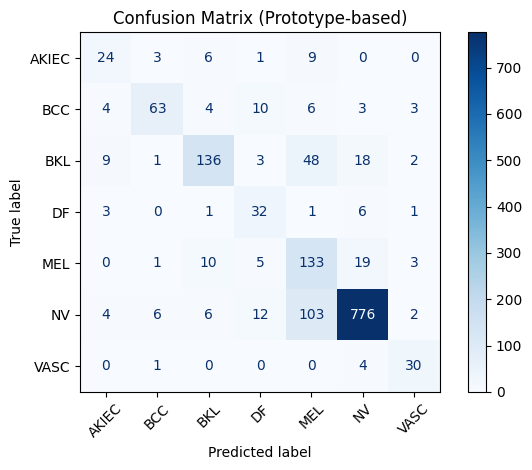

In [14]:
evaluate_on_test(model, test_dataset, support_shots=5)


[Epoch 1] Loss: 1.7755, Acc: 52.34%
[Epoch 2] Loss: 0.9232, Acc: 66.26%
[Epoch 3] Loss: 0.7121, Acc: 73.97%
[Epoch 4] Loss: 0.5505, Acc: 80.09%
[Epoch 5] Loss: 0.4733, Acc: 82.69%
[Epoch 6] Loss: 0.4080, Acc: 84.86%
[Epoch 7] Loss: 0.3289, Acc: 87.69%
[Epoch 8] Loss: 0.2927, Acc: 89.86%
[Epoch 9] Loss: 0.2327, Acc: 91.43%
[Epoch 10] Loss: 0.2304, Acc: 91.57%
[Epoch 11] Loss: 0.2106, Acc: 92.31%
[Epoch 12] Loss: 0.2000, Acc: 93.03%
[Epoch 13] Loss: 0.1578, Acc: 94.37%
[Epoch 14] Loss: 0.1416, Acc: 94.94%
[Epoch 15] Loss: 0.1311, Acc: 95.34%
[Epoch 16] Loss: 0.1173, Acc: 96.11%
[Epoch 17] Loss: 0.1210, Acc: 95.80%
[Epoch 18] Loss: 0.0967, Acc: 96.66%
[Epoch 19] Loss: 0.0870, Acc: 97.29%
[Epoch 20] Loss: 0.0839, Acc: 96.97%
[Epoch 21] Loss: 0.0853, Acc: 96.94%
[Epoch 22] Loss: 0.0692, Acc: 97.57%
[Epoch 23] Loss: 0.0681, Acc: 97.71%
[Epoch 24] Loss: 0.0696, Acc: 97.54%
[Epoch 25] Loss: 0.0563, Acc: 98.23%
[Epoch 26] Loss: 0.0550, Acc: 98.03%
[Epoch 27] Loss: 0.0495, Acc: 98.37%
[Epoch 28]

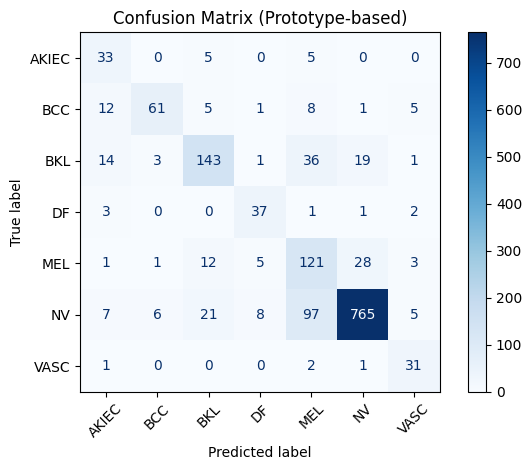

In [13]:
# 10-shot
model = ProtoNet().to(device)
train_protonet(
    model,
    fs_dataset,
    device,
    n_way=7,
    k_shot=10,
    q_queries=5,
    epochs=50
)
evaluate_on_test(model, test_dataset, support_shots=10)


**Relational Network**

In [22]:
import torch
from torch import nn
from torchvision import models

# Encoder
class RelationEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b3(weights='DEFAULT')
        base.classifier = nn.Identity()
        self.encoder = base
        self.output_dim = 1536

        # Fine-tuning parcial (igual que antes)
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.features[5:].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.encoder(x)
    
class RelationModule(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relation = nn.Sequential(
            nn.Linear(input_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, query, support):
        # query, support: [N, C]
        # concatenar a lo largo de la última dimensión
        x = torch.cat([query, support], dim=-1)  # [N, C*2]
        return self.relation(x).squeeze(-1)  # [N]

In [2]:
def train_relationnet(encoder, relation_module, dataset, device, n_way=5, k_shot=5, q_queries=15, episodes=100, epochs=20):
    encoder.train()
    relation_module.train()

    optimizer = torch.optim.Adam(
        list(filter(lambda p: p.requires_grad, encoder.parameters())) +
        list(relation_module.parameters()),
        lr=1e-4
    )
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        losses, accs = [], []

        for _ in range(episodes):
            sx, sy, qx, qy = dataset.get_episode(n_way, k_shot, q_queries)
            sx, sy, qx, qy = sx.to(device), sy.to(device), qx.to(device), qy.to(device)

            support_feat = encoder(sx)
            query_feat = encoder(qx)

            prototypes = torch.stack([support_feat[sy == i].mean(0) for i in range(n_way)])

            # Calcular relaciones para cada query con cada prototype
            relations = []
            for q in query_feat:
                pairs = torch.cat([prototypes, q.expand(n_way, -1)], dim=1)
                relations.append(relation_module(pairs))
            relations = torch.stack(relations).squeeze()  # shape: [n_queries, n_way]

            # Targets: para cada query, su clase correcta (0..n_way)
            labels_onehot = torch.zeros(len(qy), n_way).to(device)
            labels_onehot[range(len(qy)), qy] = 1

            loss = loss_fn(relations, labels_onehot)
            acc = (relations.argmax(dim=1) == qy).float().mean().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            accs.append(acc)

        print(f"[Epoch {epoch+1}] Loss: {np.mean(losses):.4f}, Acc: {np.mean(accs)*100:.2f}%")

In [25]:
def evaluate_relationnet(encoder, relation_module, dataset, support_shots=5):
    import torch
    from torch.utils.data import DataLoader
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    encoder.eval()
    relation_module.eval()
    device = next(encoder.parameters()).device

    # Extraer nombres de clases
    class_to_idx = dataset.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    # Obtener prototipos de soporte
    support_prototypes = []
    for cls in sorted(dataset.classes):
        indices = dataset.class_to_indices[cls][:support_shots]
        support_imgs = [dataset.dataset[i][0].unsqueeze(0).to(device) for i in indices]
        support_batch = torch.cat(support_imgs, dim=0)
        with torch.no_grad():
            proto_feat = encoder(support_batch).mean(dim=0)
        support_prototypes.append(proto_feat)

    support_prototypes = torch.stack(support_prototypes)  # [n_classes, feat_dim]

    # DataLoader para test
    test_loader = DataLoader(dataset.dataset, batch_size=16, shuffle=False)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            query_feats = encoder(x_batch)  # [B, feat_dim]

            n = query_feats.size(0)
            m = support_prototypes.size(0)

            q_expand = query_feats.unsqueeze(1).expand(n, m, -1)
            s_expand = support_prototypes.unsqueeze(0).expand(n, m, -1)

            pairs = torch.cat([q_expand, s_expand], dim=-1)  # [n_queries, n_classes, 2*feat_dim]
            scores = relation_module(pairs)  # [n_queries, n_classes]

            preds = scores.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Clasificación
    print("\nClassification Report (RelationNet Evaluation):")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Relation Network - Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
from torchvision import transforms
from torchvision import models

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_path = r"D:\TFM\data\train_val_full"
fs_dataset = FewShotISICDataset(data_path, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = RelationEncoder().to(device)
relation_net = RelationModule(input_dim=encoder.output_dim).to(device)


train_relationnet(
    encoder,
    relation_net,
    fs_dataset,
    device,
    n_way=7,      # usar todas las clases
    k_shot=5,     # comparación justa con ProtoNet y supervised
    q_queries=5,
    epochs=30
)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (755961102.py, line 28)


Classification Report (RelationNet Evaluation):
              precision    recall  f1-score   support

       AKIEC     0.6842    0.6047    0.6420        43
         BCC     0.8375    0.7204    0.7746        93
         BKL     0.6502    0.7281    0.6870       217
          DF     0.6667    0.5455    0.6000        44
         MEL     0.4970    0.4854    0.4911       171
          NV     0.8855    0.8592    0.8721       909
        VASC     0.3939    0.7429    0.5149        35

    accuracy                         0.7705      1512
   macro avg     0.6593    0.6694    0.6545      1512
weighted avg     0.7814    0.7705    0.7737      1512



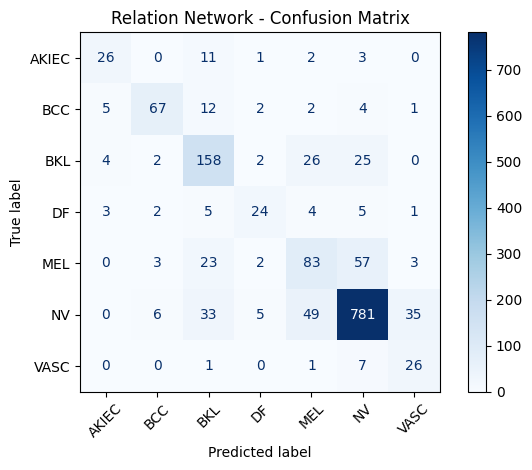

In [26]:
test_path = r"D:\TFM\ISIC2018\test"
test_dataset = FewShotISICDataset(test_path, transform=transform)

evaluate_relationnet(encoder, relation_net, test_dataset, support_shots=5)


**Machine Networks**

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# MatchingNet Encoder
class MatchingEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b3(weights='DEFAULT')
        base.classifier = nn.Identity()
        self.encoder = base
        self.output_dim = 1536

        # Fine-tune parcialmente
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.features[5:].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.encoder(x)

# Matching Network (cosine similarity + attention)
class MatchingNet(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, support, support_labels, query):
        # Normalizar embeddings
        support = F.normalize(support, dim=-1)
        query = F.normalize(query, dim=-1)

        # Calcular similitud coseno [n_query, n_support]
        sims = torch.matmul(query, support.T)  # [Q, S]
        attention = F.softmax(sims, dim=1)     # [Q, S]

        # Convertir support_labels a one-hot
        n_classes = torch.unique(support_labels).numel()
        one_hot = F.one_hot(support_labels, num_classes=n_classes).float()  # [S, C]

        # Weighted sum (attention × labels)
        output = torch.matmul(attention, one_hot)  # [Q, C]
        return output


In [28]:
def train_matchingnet(encoder, matcher, dataset, device, n_way=5, k_shot=5, q_queries=15, episodes=100, epochs=20):
    encoder.train()
    matcher.train()

    optimizer = torch.optim.Adam(
        list(filter(lambda p: p.requires_grad, encoder.parameters())),
        lr=1e-4
    )
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        losses, accs = [], []

        for _ in range(episodes):
            sx, sy, qx, qy = dataset.get_episode(n_way, k_shot, q_queries)
            sx, sy, qx, qy = sx.to(device), sy.to(device), qx.to(device), qy.to(device)

            support_feat = encoder(sx)     # [S, D]
            query_feat = encoder(qx)       # [Q, D]

            scores = matcher(support_feat, sy, query_feat)  # [Q, C]

            loss = loss_fn(scores, qy)
            acc = (scores.argmax(dim=1) == qy).float().mean().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            accs.append(acc)

        print(f"[Epoch {epoch + 1}] Loss: {sum(losses)/len(losses):.4f}, Acc: {sum(accs)/len(accs)*100:.2f}%")


In [29]:
encoder = MatchingEncoder().to(device)
matcher = MatchingNet().to(device)

train_matchingnet(
    encoder,
    matcher,
    fs_dataset,
    device,
    n_way=7,       # 7 clases (ISIC)
    k_shot=5,
    q_queries=5,
    epochs=30
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 20.60 GiB is allocated by PyTorch, and 94.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

**5. EXTRAS**

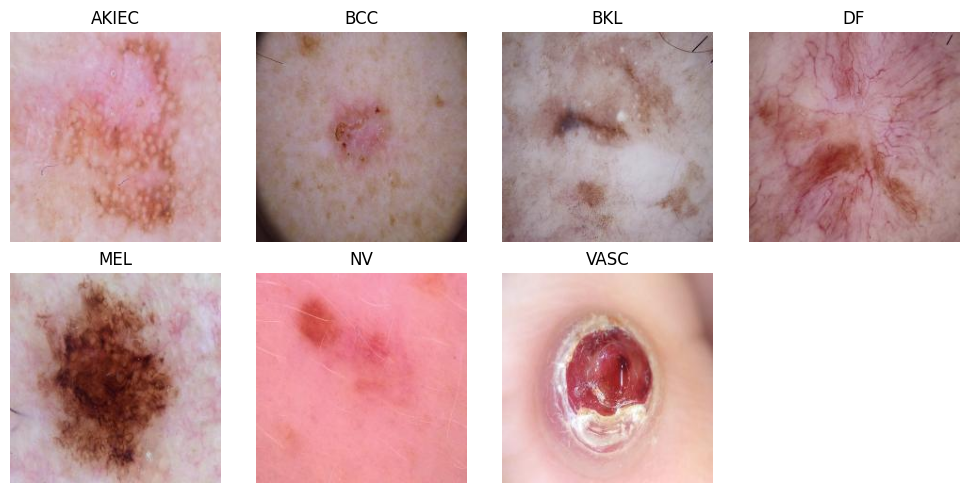

In [ ]:
test_dataset1 = datasets.ImageFolder(test_pre)  

class_names = test_dataset1.classes

fig, axes = plt.subplots(2, 4, figsize=(10, 5))  

axes = axes.flatten()

for i, class_name in enumerate(class_names):
    class_idx = test_dataset1.class_to_idx[class_name]
    class_indices = [idx for idx, label in enumerate(test_dataset1.targets) if label == class_idx]
    
  
    img_idx = class_indices[0]
    image, _ = test_dataset1[img_idx]  
    
    
    image = np.array(image)  
    
    
    axes[i].imshow(image)
    axes[i].axis('off') 
    axes[i].set_title(class_name) 
    
    
    axes[i].set_aspect('equal')


fig.delaxes(axes[-1])
plt.savefig('class_images.pdf', dpi=600) 

plt.tight_layout()
plt.show()

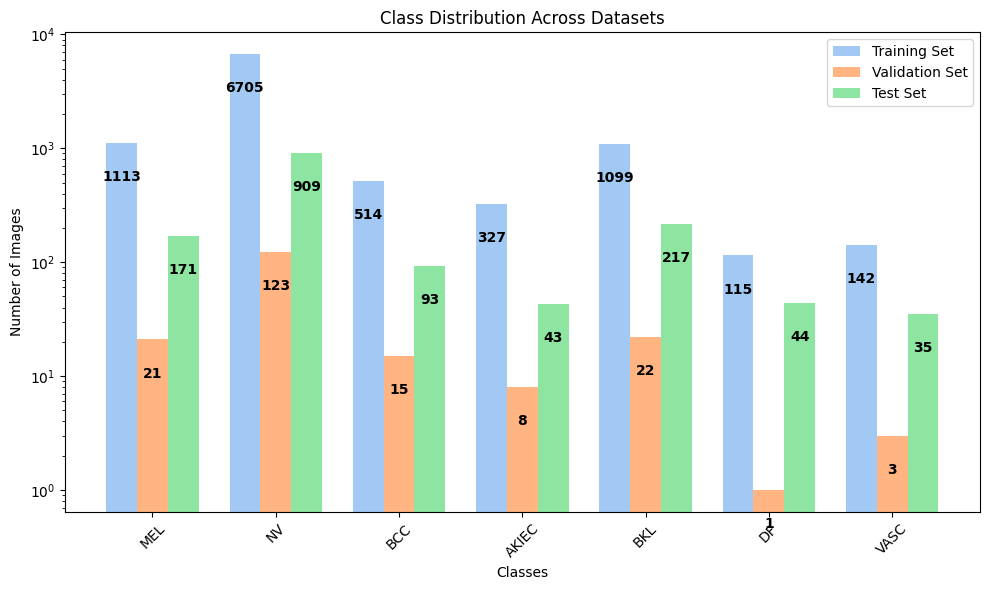

In [ ]:
train_class_counts = train_df.iloc[:, 1:].sum(axis=0)  
val_class_counts = val_df.iloc[:, 1:].sum(axis=0) 
test_class_counts = test_df.iloc[:, 1:].sum(axis=0)  


fig, ax = plt.subplots(figsize=(10, 6))  


x = range(len(classes))


bar_width = 0.25


train_bars = ax.bar([p - bar_width for p in x], train_class_counts.values, bar_width, label='Training Set', color=sns.color_palette("pastel", 7)[0])
val_bars = ax.bar(x, val_class_counts.values, bar_width, label='Validation Set', color=sns.color_palette("pastel", 7)[1])
test_bars = ax.bar([p + bar_width for p in x], test_class_counts.values, bar_width, label='Test Set', color=sns.color_palette("pastel", 7)[2])


for bar in train_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

ax.set_yscale('log')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('class_distribution_high_quality.pdf', dpi=600)  # Save as PDF with high quality

plt.show()
